Business Understanding

Cybercrime, crimes that target or use devices or computer networks, are rapidly proliferating and evolving as digital transformation,from consumer experiences to enterprise wide adoption, becomes the new standard way of life. In fact, since the pandemic, there has been an increase of cybercrime by up to 600%, predominantly through extortion, identity theft, personal data breach, non-payment, and phishing attacks. A common cybercrime scenario involve fileless malware, an attack which occurs by embedding malicious code in PowerShell.

In this project, we aim to detect the presence of obfuscated content within a given PowerShell script. Through supervised machine learning methods and dimensionality reduction we seek to identify and analyze the presence of obfuscated content within PowerShell script. While our focus is narrowly centered on identifying obfuscated scripts and not determining if the script is, in fact, malicious, with further investments, this effort could be operationalized as part of a broader enterprise data security strategy to mitigate cybercrimes.

In [59]:
import sys
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set(style='white')

%matplotlib inline

In [60]:
# Define Global variables
# Define Global

#original_data_path = "../dataset/all.csv" # this file is originally zipped
original_data_path = "../dataset/all_with_labels.csv" # With Labels 

# Some columns are empty for future use. Set to False to not include them
include_unused_columns = False 

# Define unused columns here
unused_columns = ['vt_harmless', 'vt_undetected', 'vt_malicious', 'vt_suspicious',
				  'avclass_name', 'obf_name']

# Remove the string columns sha1 and fpath
include_sha1_fpath = False

# Remove them from the list if set to False 
if include_sha1_fpath == False:
	unused_columns.append('sha1')
	unused_columns.append('fpath')

In [61]:
#with labels
#original_data_path= (r'C:\Users\adalidra\OneDrive - Microsoft\AA_Top_Folder\Data Science Program\DS7331\Term Project\all_with_labels.csv')

In [62]:
def create_workable_data(file_path, lst_unused_columns):
	'''import the dataset and format the data into a pandas dataframe.
	+ Read in CSV as dataframe
	+ Remove extra header if there is one 
	+ Remove unused columns if set 
	+ Typecast DataTypes to string and integers
	+ Returns Pandas DataFrame object'''
	try:
		pd_df = pd.read_csv(file_path) # Read in CSV as dataframe
	except FileNotFoundError():
		print("Could not find data file. Make sure the file is unzipped...")
		sys.exit(1)
		
	# Remove Duplicates
	pd_df.drop_duplicates('sha1', inplace=True)
		
	# Check to see if duplicate header is present. Remove if there is 
	if pd_df.at[0, 'sha1'] == 'sha1':
		pd_df = pd_df.iloc[1:] # .iloc[] integer-loc based indexing for selecting by position 
		
	# Remove unused columns if global var "include_unused_columns" is set to False
	if include_unused_columns == False:
		pd_df = pd_df.drop(columns=lst_unused_columns)

	# Convert all to float 
	for col in pd_df.columns.tolist():
		pd_df[col] = pd_df[col].astype(float)
	
	return(pd_df)

In [63]:
def remove_df_rows(data_as_df, char_limit):
    '''Function to remove rows based on the char_limit. char_limit is depicted by
    the doc_char_count feature. 
    @Params:
    - data_as_df (Pandas DataFrame): Data set
    - char_limit (int): Will remove all rows less than or equal to this value
    '''
    working_data = data_as_df # Copy to return
    indx_to_remove = [] # List of index values to remove from DF
    # Find Index's of rows that match the use case 
    for indx in working_data.index.values:
        if float(working_data.at[indx, 'doc_char_count']) <= char_limit:
            indx_to_remove.append(indx)
        else:
            pass

    print('{} row(s) removed that had a document char lenth of {} or less.'.format(
        len(indx_to_remove), char_limit
    ))

    return(working_data.drop(indx_to_remove))

In [64]:
data_df = create_workable_data(original_data_path, unused_columns) # Create a Data Frame from the csv
data_df = remove_df_rows(data_df, 0) # Remove rest of the empty rows 
data_df['is_obf'] = pd.to_numeric(data_df['is_obf'], downcast='integer')
data_df.drop(data_df.loc[data_df['is_obf']==2].index, inplace=True)

1 row(s) removed that had a document char lenth of 0 or less.


#Data Understanding

##Data Meaning

The original PowerShellCorpus.zip contains 409876 PowerShell scripts collected in 2017 from GitHub, Technet, PowerShellGallery, and other sources.

Scripts from the corpus were initially unlabled and represented as, good vs bad, or obfuscated vs clean.

The scripts were individually processed to obtain the features discussed below.

The PowerShellCorpus.zip was processed to obtain a series of features with which we hope to identify the presence or absence of obfuscation through varying methods. The data set contains 87 features across 409876 observations. A brief description of each feature is provided below:

Feature Name	Description
SHA1	SHA1 cryptographic hash of the input file
fpath	Fully qualified path to the input file
vt_harmless	No data, reserved for future use
vt_undetected	No data, reserved for future use
vt_malicious	No data, reserved for future use
vt_suspicious	No data, reserved for future use
avclass_name	No data, reserved for future use
is_obf	3 level factor for obfuscation status. 1:known obfuscated, 2:unknown, 3: known unobfuscated
obf_name	No data, reserved for future use
char_hash_count	Count of the number of times the literal character '#' (0x23) was found in the file
char_paren_count	Count of the number of times the literal character '(' (0x28) and ')' (0x29) was found in the file
char_brack_count	Count of the number of times the literal character '[' (0x5B) and ']' (0x5D) was found in the file
char_brace_count	Count of the number of times the literal character '{' (0x7B and '}' (0x7D) was found in the file
char_bkslash_count	Count of the number of times the literal character '' (0x5C) was found in the file
char_fwslash_count	Count of the number of times the literal character '/' (0x2F) was found in the file
char_dollar_count	Count of the number of times the literal character '$' (0x24) was found in the file
char_squote_count	Count of the number of times the literal character "'" (0x27) was found in the file
char_dquote_count	Count of the number of times the literal character '"' (0x22) was found in the file
char_bktick_count	Count of the number of times the literal character '`' (0x60) was found in the file
char_colon_count	Count of the number of times the literal character ':' (0x3A) was found in the file
char_scolon_count	Count of the number of times the literal character ';' (0x3B) was found in the file
char_star_count	Count of the number of times the literal character '*' (0x2A) was found in the file
char_minus_count	Count of the number of times the literal character '-' (0x2D) was found in the file
char_plus_count	Count of the number of times the literal character '+' (0x2B) was found in the file
char_percent_count	Count of the number of times the literal character '%' (0x25) was found in the file
char_carrot_count	Count of the number of times the literal character '^' (0x5E) was found in the file
char_comma_count	Count of the number of times the literal character ',' (0x2C) was found in the file
char_period_count	Count of the number of times the literal character '.' (0x2E) was found in the file
char_glthan_count	Count of the number of times the literal character '<' (0x3C) and '>' (0x3E) was found in the file
char_num_count	Count of the number of times numeric characters '0' (0x30) through '9' (0x39) were found in the file
char_ucase_count	Count of the number of times uppercase alphabetic characters 'A' (0x41) through 'Z' (0x5A) were found in the file
char_lcase_count	Count of the number of times uppercase alphabetic characters 'a' (0x61) through 'z' (0x7A) were found in the file
char_eq_count	Count of the number of times the literal character '=' (0x3D) was found in the file
char_space_count	Count of the number of times the literal character ' ' (0x20) was found in the file
char_pipe_count	Count of the number of times the literal character '|' (0x7C) was found in the file
char_uscore_count	Count of the number of times the literal character '_' (0x5F) was found in the file
char_amp_count	Count of the number of times the literal character '&' (0x26) was found in the file
char_excl_count	Count of the number of times the literal character '!' (0x21) was found in the file
doc_char_count	Count of the number of characters in the file
doc_avg_line_len	Mean number of characters per line in the file
doc_min_line_len	Minimum number of characters per line in the file
doc_max_line_len	Maximum number of characters per line in the file
doc_line_count	Count of the number of lines in the file
doc_mcomment_count	Count of the number of multiline comment sequences in the file '<#' (0x3C 0x23) and '#>' (0x23 0x3E)
doc_entropy	Calculation of the Shannon entropy for the file
doc_dtype_bool_word_count	Count of the number of times the word 'bool' is present in the file
doc_dtype_char_word_count	Count of the number of times the word 'char' is present in the file
doc_dtype_int_word_count	Count of the number of times the word 'int' is present in the file
doc_dtype_long_word_count	Count of the number of times the word 'long' is present in the file
doc_dtype_float_word_count	Count of the number of times the word 'float' is present in the file
doc_dtype_single_word_count	Count of the number of times the word 'single' is present in the file
doc_dtype_double_word_count	Count of the number of times the word 'double' is present in the file
doc_dtype_decimal_word_count	Count of the number of times the word 'decimal' is present in the file
doc_keyword_begin_word_count	Count of the number of times the word 'begin' is present in the file
doc_keyword_break_word_count	Count of the number of times the word 'break' is present in the file
doc_keyword_catch_word_count	Count of the number of times the word 'catch' is present in the file
doc_keyword_class_word_count	Count of the number of times the word 'class' is present in the file
doc_keyword_continue_word_count	Count of the number of times the word 'continue' is present in the file
doc_keyword_data_word_count	Count of the number of times the word 'data' is present in the file
doc_keyword_define_word_count	Count of the number of times the word 'define' is present in the file
doc_keyword_do_word_count	Count of the number of times the word 'do' is present in the file
doc_keyword_dynamicparam_word_count	Count of the number of times the word 'dynamicparam' is present in the file
doc_keyword_else_word_count	Count of the number of times the word 'else' is present in the file
doc_keyword_elseif_word_count	Count of the number of times the word 'elseif' is present in the file
doc_keyword_end_word_count	Count of the number of times the word 'end' is present in the file
doc_keyword_enum_word_count	Count of the number of times the word 'enum' is present in the file
doc_keyword_exit_word_count	Count of the number of times the word 'exit' is present in the file
doc_keyword_filter_word_count	Count of the number of times the word 'filter' is present in the file
doc_keyword_finally_word_count	Count of the number of times the word 'finally' is present in the file
doc_keyword_foreach_word_count	Count of the number of times the word 'foreach' is present in the file
doc_keyword_from_word_count	Count of the number of times the word 'from' is present in the file
doc_keyword_function_word_count	Count of the number of times the word 'function' is present in the file
doc_keyword_hidden_word_count	Count of the number of times the word 'hidden' is present in the file
doc_keyword_if_word_count	Count of the number of times the word 'if' is present in the file
doc_keyword_in_word_count	Count of the number of times the word 'in' is present in the file
doc_keyword_param_word_count	Count of the number of times the word 'param' is present in the file
doc_keyword_process_word_count	Count of the number of times the word 'process' is present in the file
doc_keyword_return_word_count	Count of the number of times the word 'return' is present in the file
doc_keyword_static_word_count	Count of the number of times the word 'static' is present in the file
doc_keyword_switch_word_count	Count of the number of times the word 'switch' is present in the file
doc_keyword_throw_word_count	Count of the number of times the word 'throw' is present in the file
doc_keyword_trap_word_count	Count of the number of times the word 'trap' is present in the file
doc_keyword_try_word_count	Count of the number of times the word 'try' is present in the file
doc_keyword_until_word_count	Count of the number of times the word 'until' is present in the file
doc_keyword_using_word_count	Count of the number of times the word 'using' is present in the file
doc_keyword_var_word_count	Count of the number of times the word 'var' is present in the file
doc_keyword_while_word_count	Count of the number of times the word 'while' is present in the file

### Data Inspection: doc Keyword Features
We begin inspecting the data set with the doc_* feature group. 

In [65]:
data_df_doc_features = data_df.loc[:, 'doc_avg_line_len':]
data_df_doc_features['is_obf'] = data_df.is_obf
print(data_df_doc_features.shape)
print(data_df_doc_features.info())

(10405, 49)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10405 entries, 384192 to 408879
Data columns (total 49 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   doc_avg_line_len                     10405 non-null  float64
 1   doc_min_line_len                     10405 non-null  float64
 2   doc_max_line_len                     10405 non-null  float64
 3   doc_line_count                       10405 non-null  float64
 4   doc_mcomment_count                   10405 non-null  float64
 5   doc_entropy                          10405 non-null  float64
 6   doc_dtype_bool_word_count            10405 non-null  float64
 7   doc_dtype_char_word_count            10405 non-null  float64
 8   doc_dtype_int_word_count             10405 non-null  float64
 9   doc_dtype_long_word_count            10405 non-null  float64
 10  doc_dtype_float_word_count           10405 non-null  float64
 11  doc_dtype_

In [66]:
data_df_doc_features.head()

doc_avg_line_len  doc_min_line_len  doc_max_line_len  doc_line_count  \
384192         80.222222               1.0             709.0            27.0   
384193         67.427572               1.0             393.0          1429.0   
384194      61020.500000               1.0          122040.0             2.0   
384195         96.278884               1.0            1922.0           251.0   
384196         77.096401               1.0             587.0           778.0   

        doc_mcomment_count  doc_entropy  doc_dtype_bool_word_count  \
384192                 0.0     2.569801                        0.0   
384193                 0.0     2.478811                        0.0   
384194                 0.0     1.977732                        0.0   
384195                 0.0     2.368537                        0.0   
384196                 0.0     2.624356                        0.0   

        doc_dtype_char_word_count  doc_dtype_int_word_count  \
384192                        0.0                       0.0   
384193                        0.0                       0.0   
384194                        0.0                       0.0   
384195                        0.0                       0.0   
384196                        0.0                       0.0   

        doc_dtype_long_word_count  ...  doc_keyword_static_word_count  \
384192                        0.0  ...                            0.0   
384193                        0.0  ...                            0.0   
384194                        0.0  ...                            0.0   
384195                        0.0  ...                            0.0   
384196                        0.0  ...                            0.0   

        doc_keyword_switch_word_count  doc_keyword_throw_word_count  \
384192                            0.0                           0.0   
384193                            0.0                           0.0   
384194                            0.0                           0.0   
384195                            0.0                           0.0   
384196                            0.0                           0.0   

        doc_keyword_trap_word_count  doc_keyword_try_word_count  \
384192                          0.0                         0.0   
384193                          0.0                         0.0   
384194                          0.0                         0.0   
384195                          0.0                         0.0   
384196                          0.0                         0.0   

        doc_keyword_until_word_count  doc_keyword_using_word_count  \
384192                           0.0                           0.0   
384193                           0.0                           0.0   
384194                           0.0                           0.0   
384195                           0.0                           0.0   
384196                           0.0                           0.0   

        doc_keyword_var_word_count  doc_keyword_while_word_count  is_obf  
384192                         0.0                           0.0       1  
384193                         0.0                           0.0       1  
384194                         0.0                           0.0       1  
384195                         0.0                           0.0       1  
384196                         0.0                           0.0       1  

[5 rows x 49 columns]

Data Quality

In [67]:
#There are zero na values because the data will designate "unknown" or "unreported" otherwise.
na_vals = data_df_doc_features.isnull().sum()
na_vals[na_vals > 0]

Series([], dtype: int64)

#Simple Statistics

##Quantitative Variables

So far, we have established there are 10405 unique entries with 50 features. In exploring the data, we can see the scripts widely vary in size. For example, doc_avg_line_len has values ranging from '0' to '3040348'. This is further supported through the statistics we ran on the feature showing a standard deviation of '7.219357e+04.' We have two levels to represent obfuscation status including, known unobfuscated and known NOT obfuscated. There are '3190' known obfuscated scripts and '7215' known not obfuscated scripts.

In [68]:
data_df_doc_features = data_df.loc[:, 'doc_avg_line_len':]
data_df_doc_features['is_obf'] = data_df.is_obf
data_df_doc_features

doc_avg_line_len  doc_min_line_len  doc_max_line_len  doc_line_count  \
384192         80.222222               1.0             709.0            27.0   
384193         67.427572               1.0             393.0          1429.0   
384194      61020.500000               1.0          122040.0             2.0   
384195         96.278884               1.0            1922.0           251.0   
384196         77.096401               1.0             587.0           778.0   
...                  ...               ...               ...             ...   
408875         51.998185               1.0             232.0           551.0   
408876         87.456790               2.0             441.0            81.0   
408877         42.828996               1.0             318.0           269.0   
408878         41.986486               0.0             222.0            74.0   
408879         46.242105               1.0             264.0            95.0   

        doc_mcomment_count  doc_entropy  doc_dtype_bool_word_count  \
384192                 0.0     2.569801                        0.0   
384193                 0.0     2.478811                        0.0   
384194                 0.0     1.977732                        0.0   
384195                 0.0     2.368537                        0.0   
384196                 0.0     2.624356                        0.0   
...                    ...          ...                        ...   
408875                 0.0     3.357969                        0.0   
408876                 0.0     2.501711                        0.0   
408877                 2.0     3.427758                        0.0   
408878                 0.0     3.674436                        0.0   
408879                 2.0     3.467044                        0.0   

        doc_dtype_char_word_count  doc_dtype_int_word_count  \
384192                        0.0                       0.0   
384193                        0.0                       0.0   
384194                        0.0                       0.0   
384195                        0.0                       0.0   
384196                        0.0                       0.0   
...                           ...                       ...   
408875                        0.0                       0.0   
408876                        0.0                       0.0   
408877                        0.0                       0.0   
408878                        0.0                       0.0   
408879                        0.0                       0.0   

        doc_dtype_long_word_count  ...  doc_keyword_static_word_count  \
384192                        0.0  ...                            0.0   
384193                        0.0  ...                            0.0   
384194                        0.0  ...                            0.0   
384195                        0.0  ...                            0.0   
384196                        0.0  ...                            0.0   
...                           ...  ...                            ...   
408875                        0.0  ...                            0.0   
408876                        0.0  ...                            0.0   
408877                        0.0  ...                            0.0   
408878                        0.0  ...                            0.0   
408879                        0.0  ...                            0.0   

        doc_keyword_switch_word_count  doc_keyword_throw_word_count  \
384192                            0.0                           0.0   
384193                            0.0                           0.0   
384194                            0.0                           0.0   
384195                            0.0                           0.0   
384196                            0.0                           0.0   
...                               ...                           ...   
408875                            0.0                           0.0   
4088

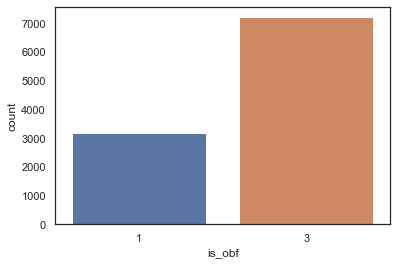

In [69]:
ax = sns.countplot(x="is_obf", data=data_df_doc_features)

In [70]:
data_df_doc_features.describe()

doc_avg_line_len  doc_min_line_len  doc_max_line_len  doc_line_count  \
count      1.040500e+04      10405.000000      1.040500e+04    10405.000000   
mean       8.866384e+03          1.207785      1.824286e+04      282.826526   
std        7.219357e+04         44.410101      1.473726e+05     1246.047428   
min        0.000000e+00          0.000000      0.000000e+00        1.000000   
25%        3.151562e+01          0.000000      1.240000e+02       39.000000   
50%        4.200000e+01          1.000000      1.870000e+02       94.000000   
75%        7.384265e+01          1.000000      3.710000e+02      219.000000   
max        3.040348e+06       4499.000000      6.080694e+06    49857.000000   

       doc_mcomment_count   doc_entropy  doc_dtype_bool_word_count  \
count        10405.000000  10405.000000               10405.000000   
mean             1.730802      2.994285                   0.029793   
std             14.301771      0.600627                   0.521064   
min              0.000000      0.000000                   0.000000   
25%              0.000000      2.513273                   0.000000   
50%              0.000000      3.170517                   0.000000   
75%              2.000000      3.407934                   0.000000   
max            846.000000      4.229025                  24.000000   

       doc_dtype_char_word_count  doc_dtype_int_word_count  \
count               10405.000000              10405.000000   
mean                    0.004037                  0.049976   
std                     0.134364                  1.351449   
min                     0.000000                  0.000000   
25%                     0.000000                  0.000000   
50%                     0.000000                  0.000000   
75%                     0.000000                  0.000000   
max                     8.000000                 98.000000   

       doc_dtype_long_word_count  ...  doc_keyword_static_word_count  \
count               10405.000000  ...                   10405.000000   
mean                    0.013936  ...                       0.069390   
std                     0.249756  ...                       0.898004   
min                     0.000000  ...                       0.000000   
25%                     0.000000  ...                       0.000000   
50%                     0.000000  ...                       0.000000   
75%                     0.000000  ...                       0.000000   
max                    20.000000  ...                      32.000000   

       doc_keyword_switch_word_count  doc_keyword_throw_word_count  \
count                   10405.000000                  10405.000000   
mean                        0.208169                      0.683325   
std                         1.531895                      4.162842   
min                         0.000000                      0.000000   
25%                         0.000000                      0.000000   
50%                         0.000000                      0.000000   
75%                         0.000000                      0.000000   
max                        73.000000                    303.000000   

       doc_keyword_trap_word_count  doc_keyword_try_word_count  \
count                 10405.000000                10405.000000   
mean                      0.011341                    0.495531   
std                       0.157676                    3.816019   
min                       0.000000                    0.000000   
25%                       0.000000                    0.000000   
50%                       0.000000                    0.000000   
75%                       0.000000                    0.000000   
max                       7.000000                  303.000000   

       doc_keyword_until_word_count  doc_keyword_using_word_count  \
count                  10405.000000                  10405.000000   
mean                       0.029313                      0.275637   
std                    

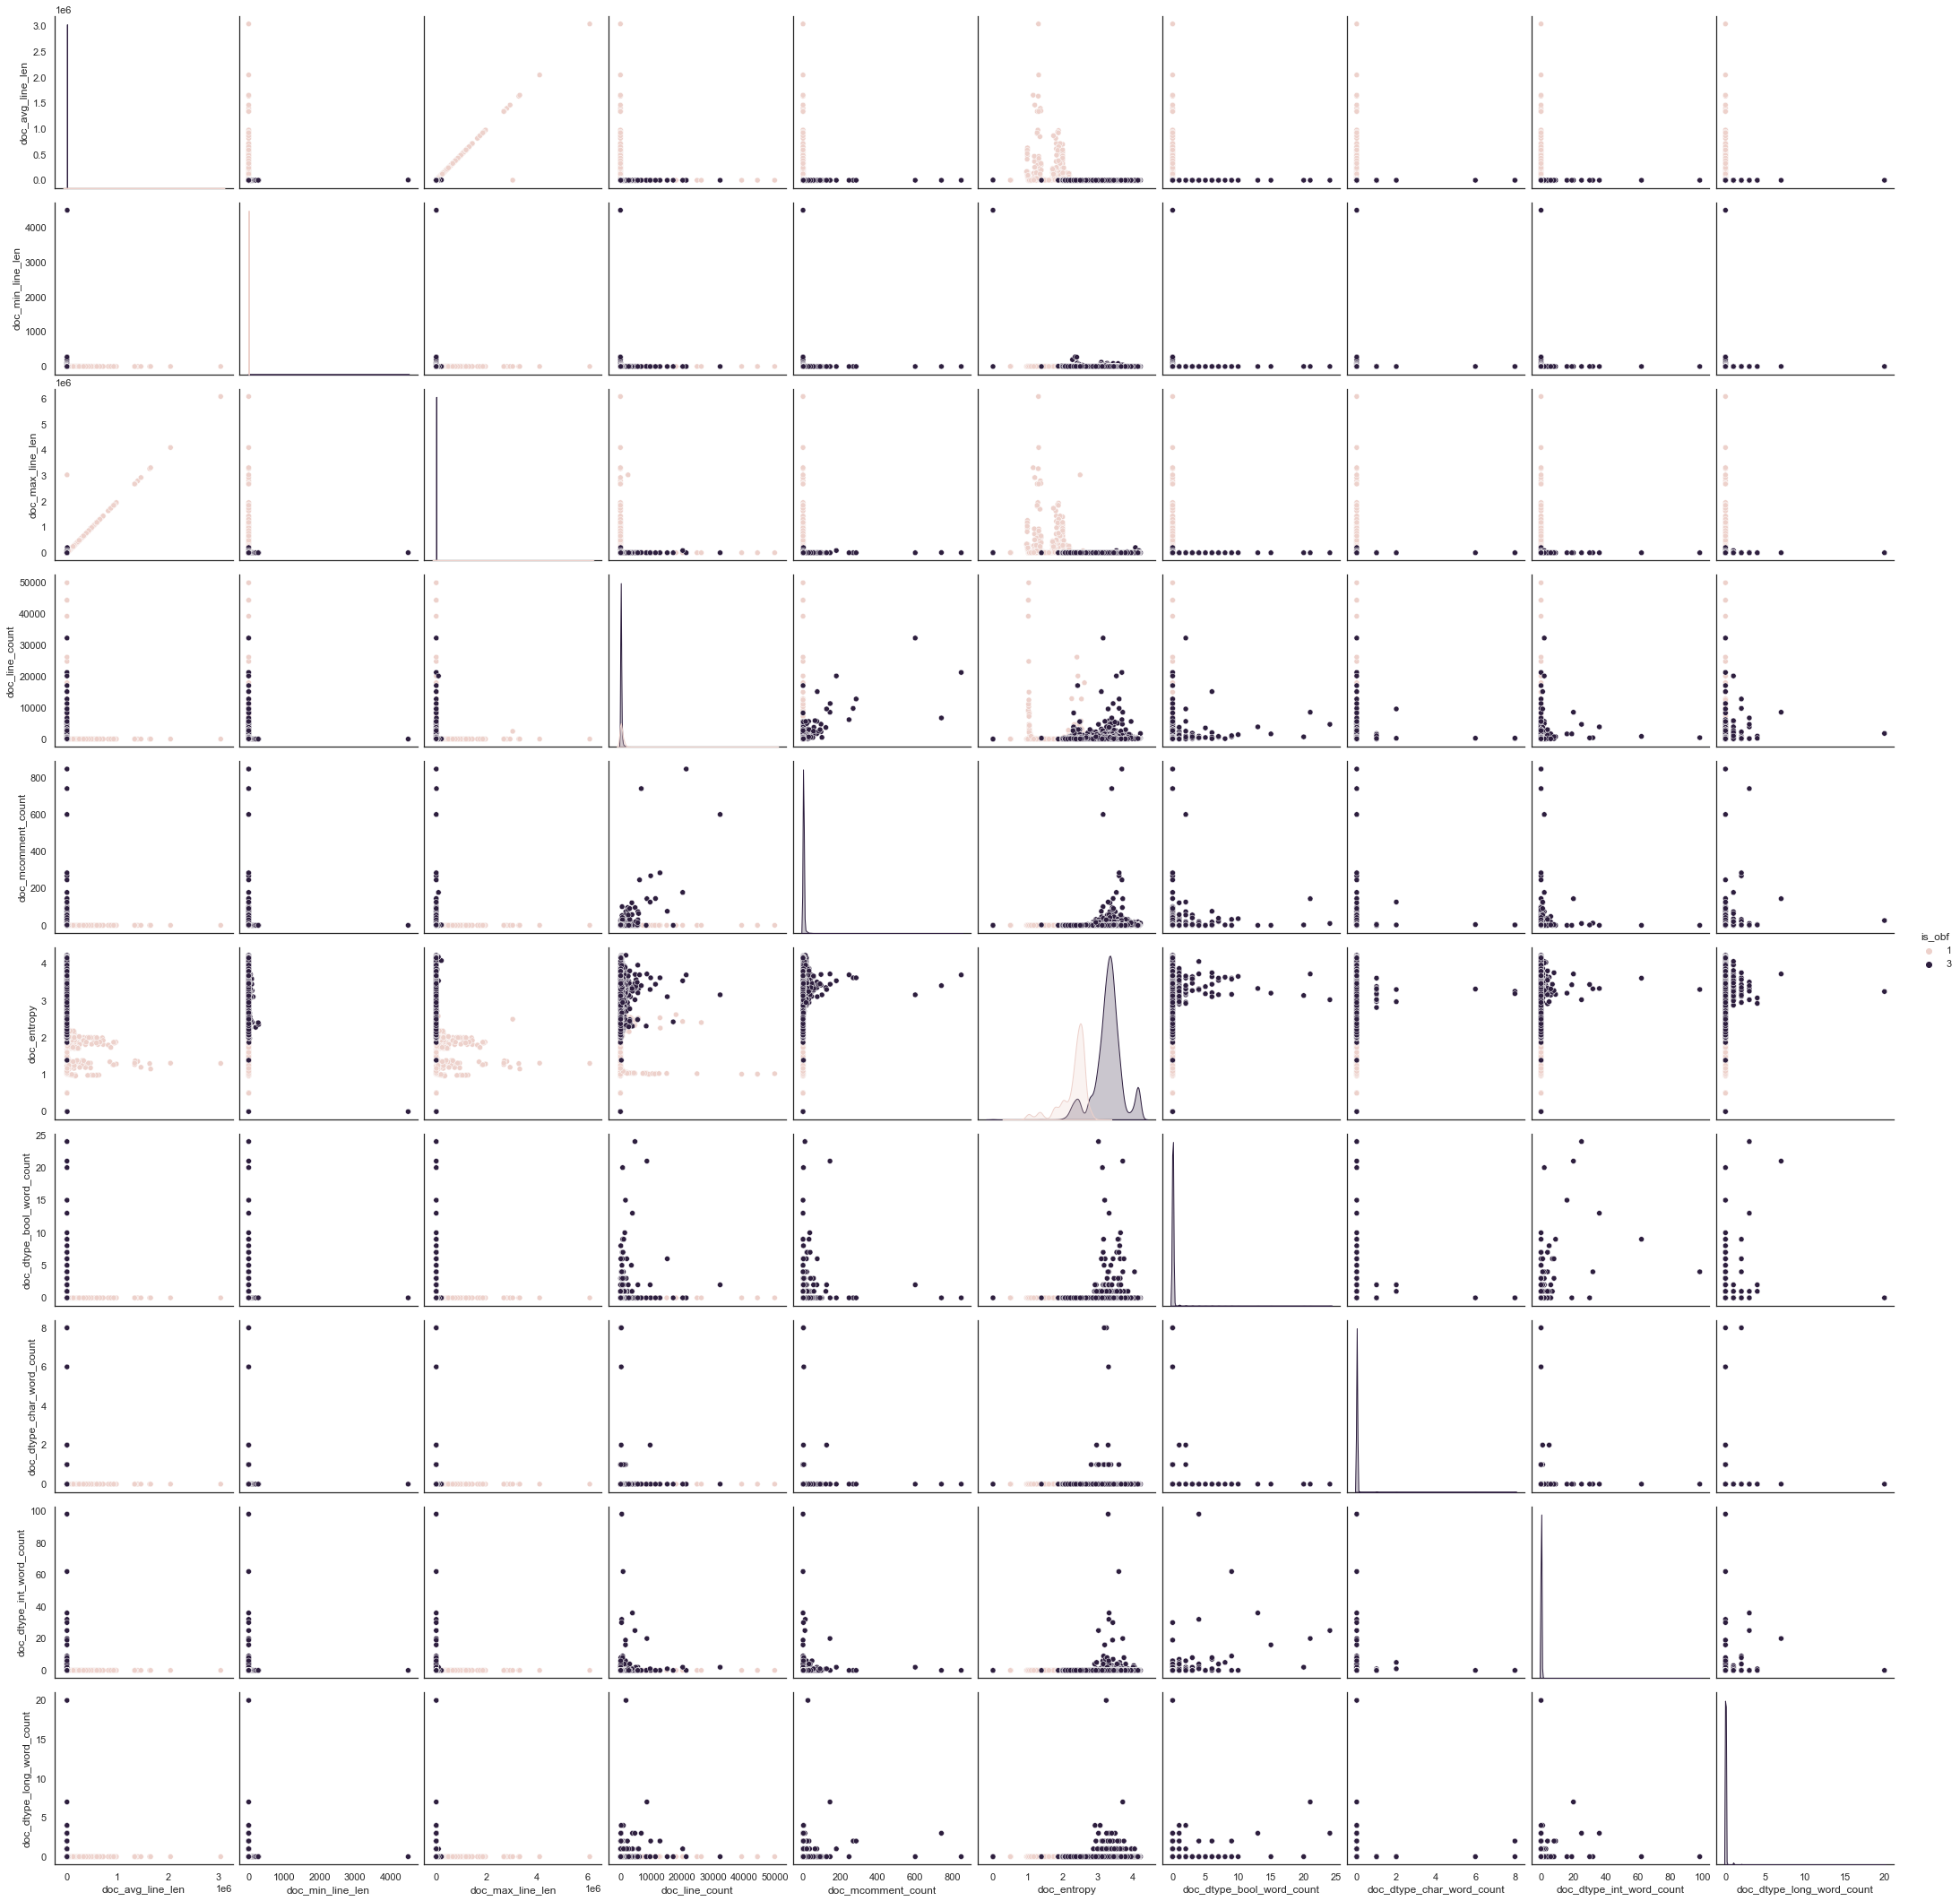

In [71]:
# Pair Plots for features 1:10
sample = data_df_doc_features.loc[:, :'doc_dtype_long_word_count']
sample['is_obf'] = data_df_doc_features.is_obf
sns.pairplot(sample, hue="is_obf", height=3)

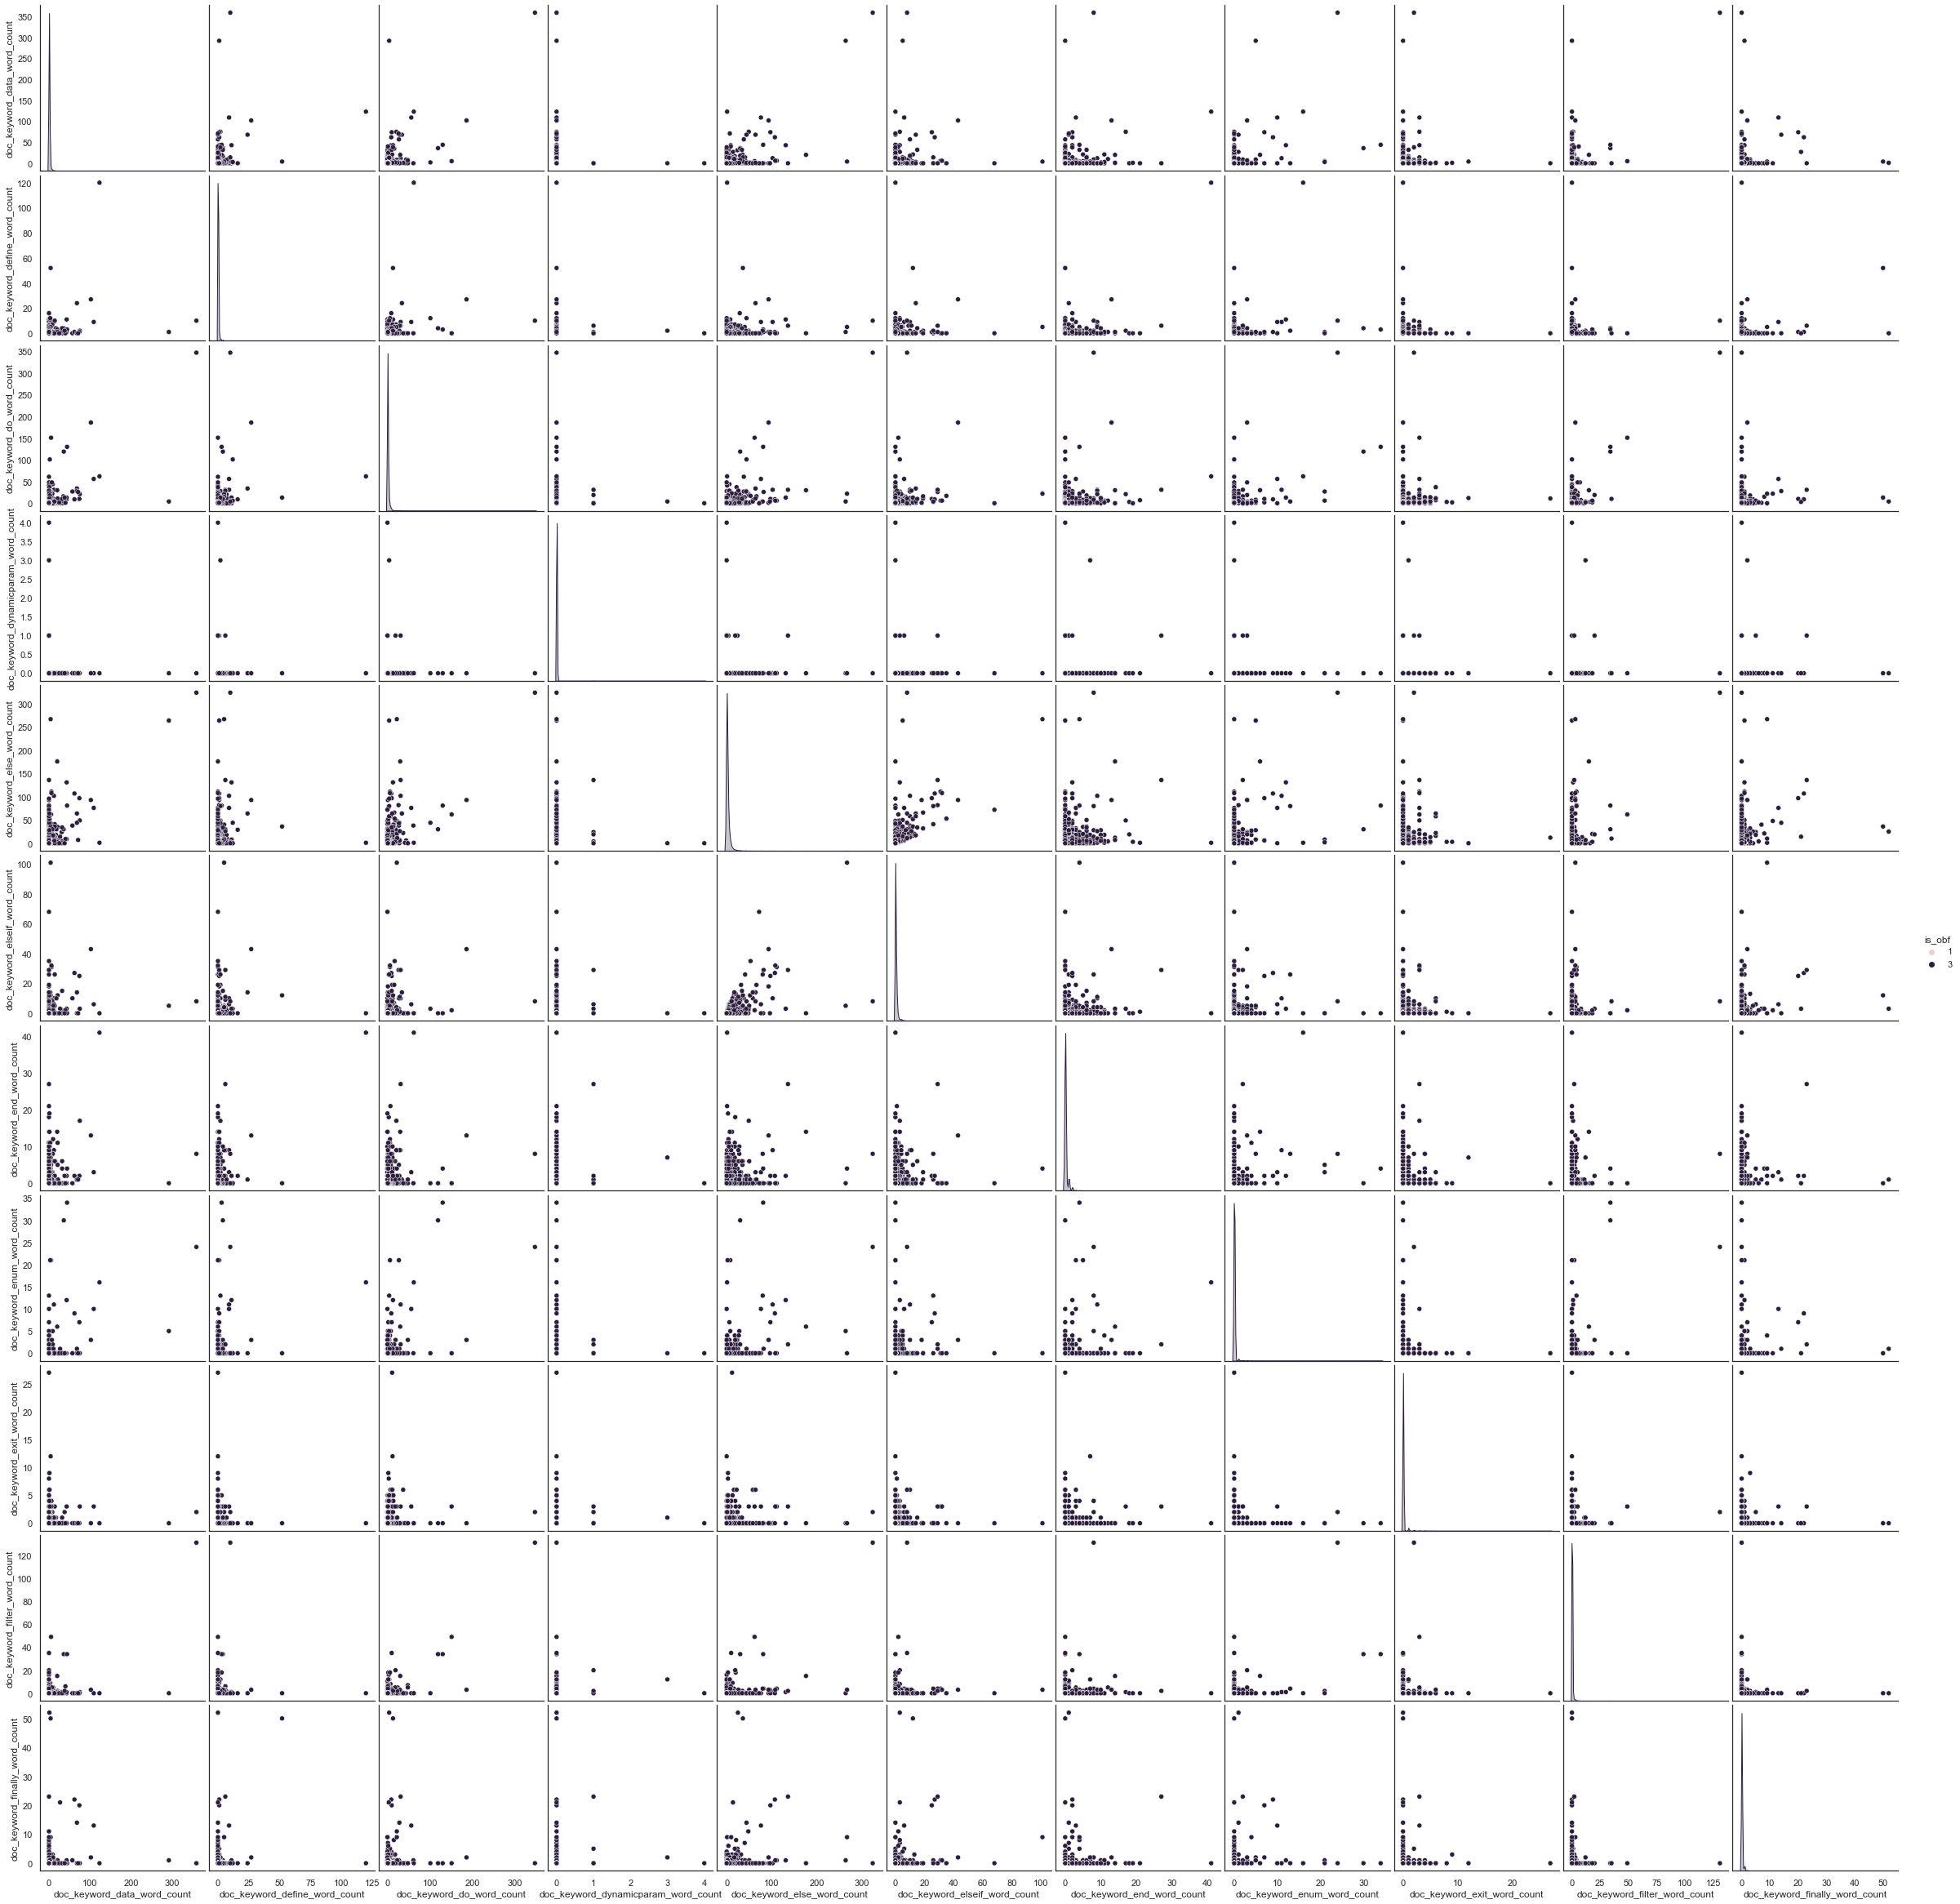

In [72]:
# Pair Plots for features 20:30
data_df_doc_features.keys()[20:]
sample = data_df_doc_features.loc[:, 'doc_keyword_data_word_count':'doc_keyword_finally_word_count']
sample['is_obf'] = data_df_doc_features.is_obf
sns.pairplot(sample, hue="is_obf", height=3)

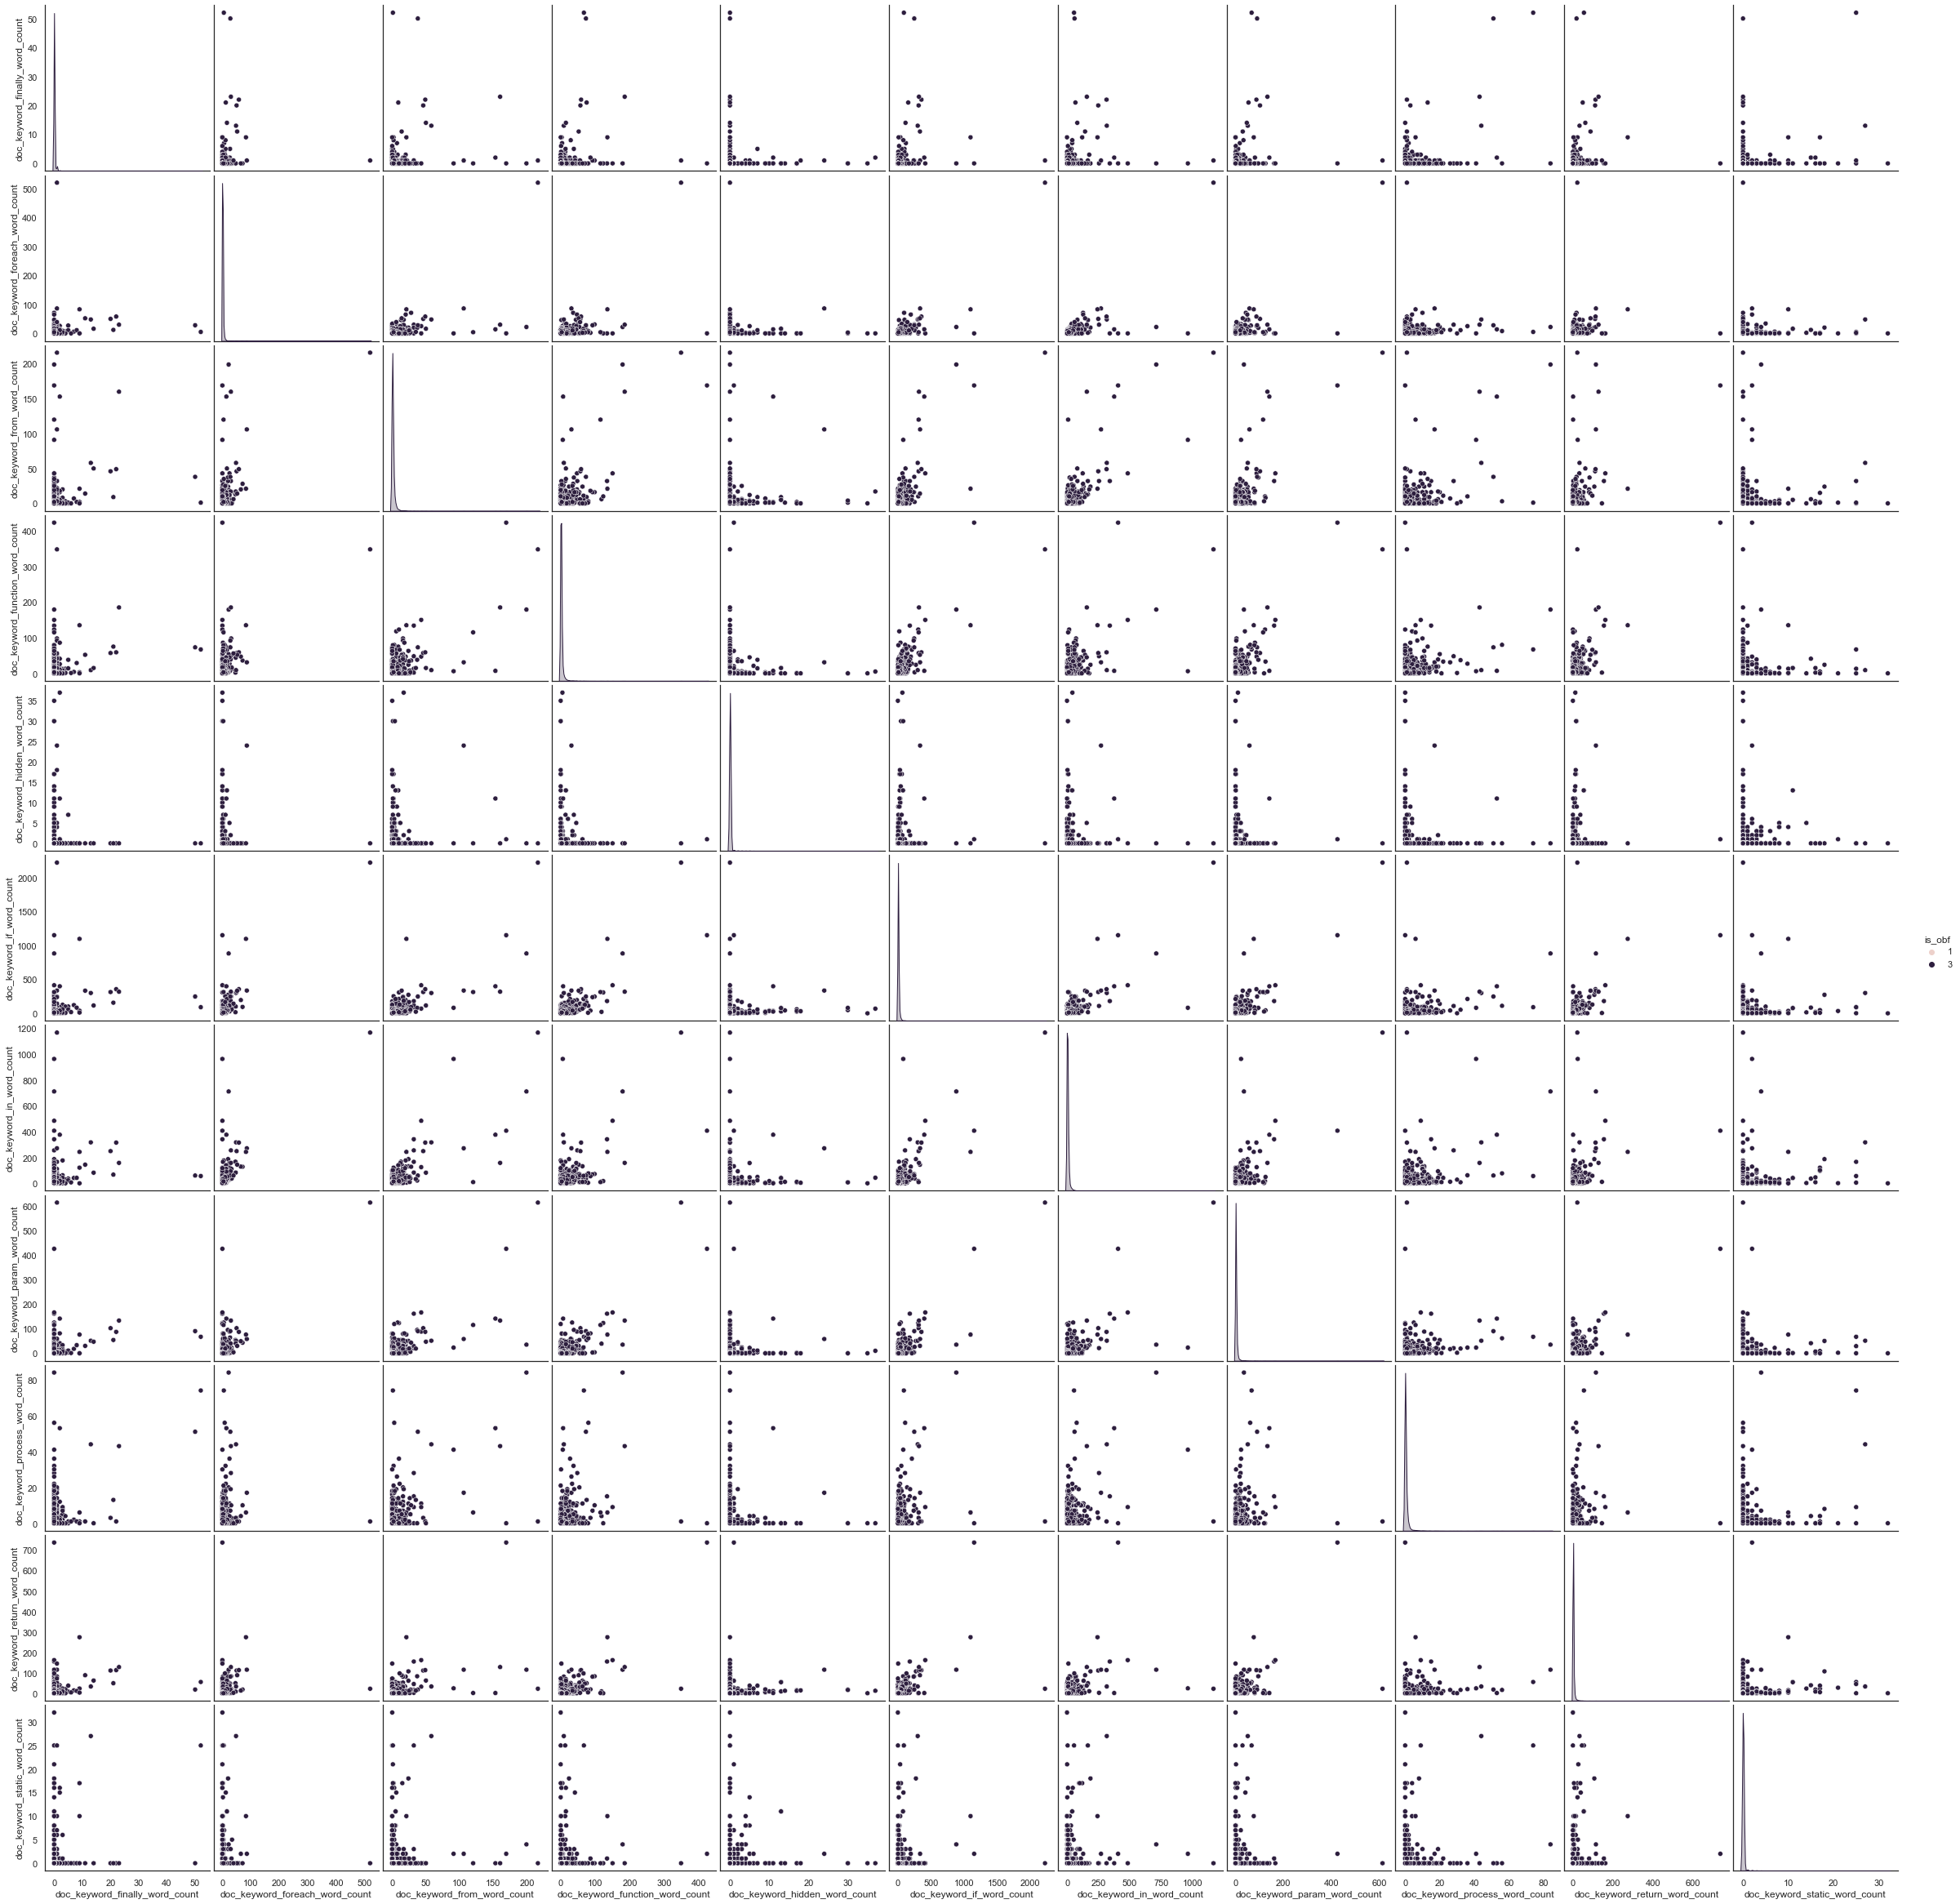

In [73]:
# Pair Plots for features 30:40
data_df_doc_features.keys()[30:]
sample = data_df_doc_features.loc[:, 'doc_keyword_finally_word_count':'doc_keyword_static_word_count']
sample['is_obf'] = data_df_doc_features.is_obf
sns.pairplot(sample, hue="is_obf", height=3)

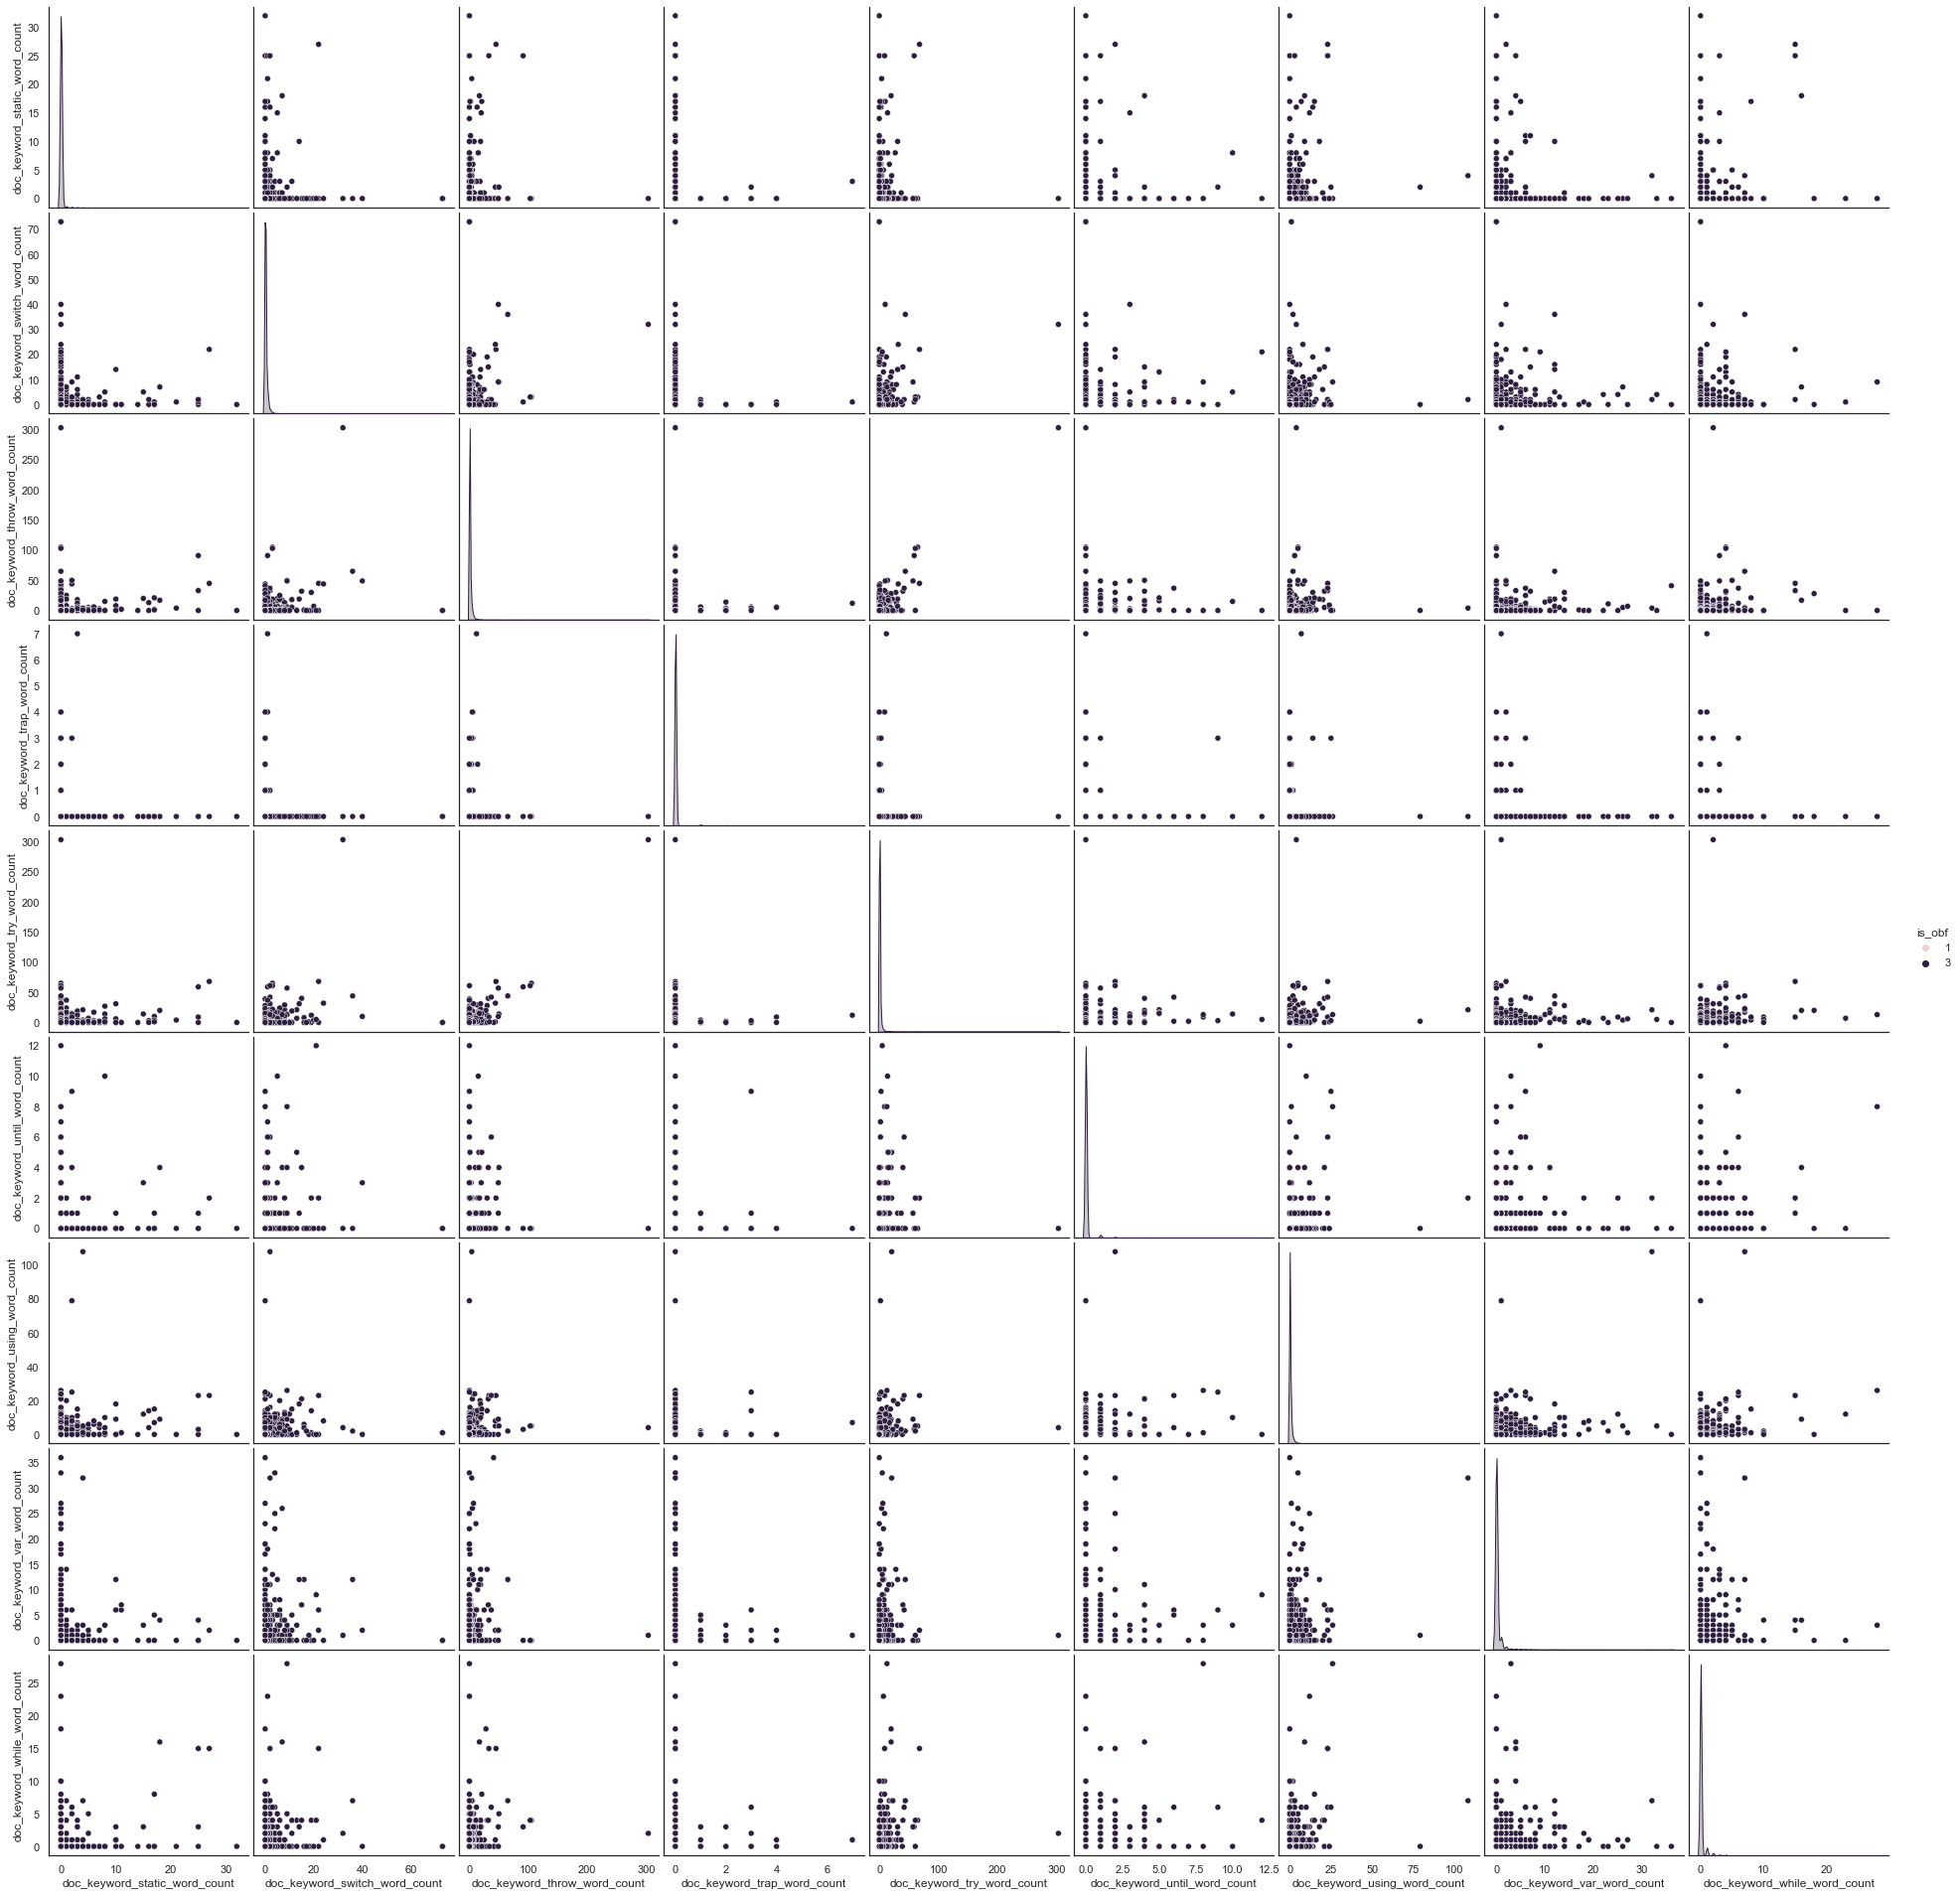

In [74]:
# Pair Plots for features 40: to end
data_df_doc_features.keys()[40:]
sample = data_df_doc_features.loc[:, 'doc_keyword_static_word_count':]
sample['is_obf'] = data_df_doc_features.is_obf
sns.pairplot(sample, hue="is_obf", height=3)

Next, we investigate the sparsity of the obfuscated scripts in the 'doc_dtype' and 'doc_keyword' features shown in the pairplots above. 

In [75]:
data_df_doc_features.keys()
output = data_df_doc_features.groupby('is_obf').describe().T
with pd.option_context('display.max_rows', len(output)):
    display(output)

is_obf                                                1              3
doc_avg_line_len                    count  3.190000e+03    7215.000000
                                    mean   2.882629e+04      41.421627
                                    std    1.281754e+05      87.122382
                                    min    2.500000e+00       0.000000
                                    25%    7.089430e+01      28.693026
                                    50%    8.049818e+01      35.219178
                                    75%    1.927375e+02      44.007109
                                    max    3.040348e+06    5147.878788
doc_min_line_len                    count  3.190000e+03    7215.000000
                                    mean   1.001254e+00       1.299099
                                    std    5.007046e-02      53.332471
                                    min    1.000000e+00       0.000000
                                    25%    1.000000e+00       0.000000
                                    50%    1.000000e+00       0.000000
                                    75%    1.000000e+00       1.000000
                                    max    3.000000e+00    4499.000000
doc_max_line_len                    count  3.190000e+03    7215.000000
                                    mean   5.893656e+04     250.774220
                                    std    2.616245e+05    2988.723982
                                    min    4.000000e+00       0.000000
                                    25%    3.530000e+02     109.000000
                                    50%    5.870000e+02     144.000000
                                    75%    1.679250e+03     201.000000
                                    max    6.080694e+06  202833.000000
doc_line_count                      count  3.190000e+03    7215.000000
                                    mean   4.533881e+02     207.415385
                                    std    1.936842e+03     749.890609
                                    min    2.000000e+00       1.000000
                                    25%    5.000000e+00      48.000000
                                    50%    1.050000e+02      92.000000
                                    75%    4.297500e+02     195.000000
                                    max    4.985700e+04   32223.000000
doc_mcomment_count                  count  3.190000e+03    7215.000000
                                    mean   0.000000e+00       2.496050
                                    std    0.000000e+00      17.119501
                                    min    0.000000e+00       0.000000
                                    25%    0.000000e+00       0.000000
                                    50%    0.000000e+00       2.000000
                                    75%    0.000000e+00       2.000000
                                    max    0.000000e+00     846.000000
doc_entropy                         count  3.190000e+03    7215.000000
                                    mean   2.307210e+00       3.298065
                                    std    3.757672e-01       0.395998
                                    min    4.967465e-01       0.000000
                                    25%    2.217270e+00       3.142316
                                    50%    2.429104e+00       3.328024
                                    75%    2.549205e+00       3.484721
                                    max    3.174324e+00       4.229025
doc_dtype_bool_word_count           count  3.190000e+03    7215.000000
                                    mean   0.000000e+00       0.042966
                                    std    0.000000e+00       0.625301
                                    min    0.000000e+00       0.000000
                                    25%    0.000000e+00       0.000000
                                    50%    0.000000e+00       0.000000
                                    75%    0.000000e+00       0.000000
                        

As shown above, presence of obfuscated scripts in these features is very sparse. We will combine all of the features starting with 'doc_type' and 'doc_keyword' into a the new feature 'doc_keywords'. 

In [76]:
data_df_doc_features['doc_keywords']= data_df_doc_features.loc[:, 'doc_entropy':].sum(axis=1)
output = data_df_doc_features.groupby('is_obf').describe().T
output

is_obf                              1            3
doc_avg_line_len count    3190.000000  7215.000000
                 mean    28826.290795    41.421627
                 std    128175.417713    87.122382
                 min         2.500000     0.000000
                 25%        70.894299    28.693026
...                               ...          ...
doc_keywords     min         1.496747     3.000000
                 25%         3.217270    10.087555
                 50%         3.429104    18.189410
                 75%         3.549205    35.005089
                 max         4.174324  6637.159648

[392 rows x 2 columns]

<AxesSubplot:xlabel='doc_keywords', ylabel='Count'>

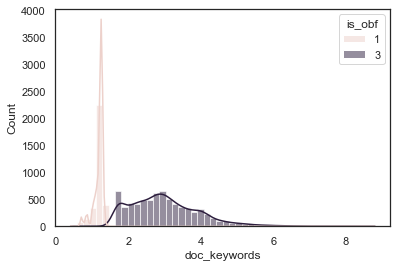

In [77]:
sns.histplot(data=data_df_doc_features, x=np.log(data_df_doc_features.doc_keywords), hue="is_obf", kde=True)

<AxesSubplot:xlabel='is_obf', ylabel='doc_keywords'>

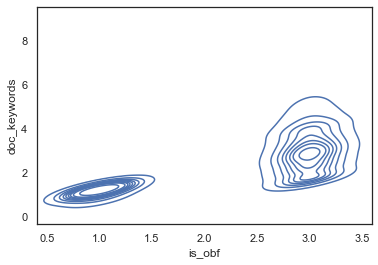

In [78]:
sns.kdeplot(x=data_df_doc_features.is_obf, y=np.log(data_df_doc_features.doc_keywords))

<AxesSubplot:xlabel='is_obf', ylabel='doc_keywords'>

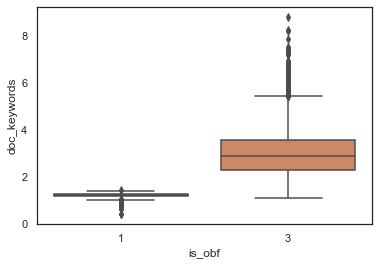

In [79]:
sns.boxplot(x=data_df_doc_features.is_obf, y=np.log(data_df_doc_features.doc_keywords))

We have aggrigated all 'doc_dtype' and 'doc_keyword' features into a new feature called 'doc_keywords'. As shown above, this new feature is statistically significant and has good separation of obfuscated vs not obfuscated catagories. 

### Data Inspection: doc Keyword Features
Next, we investigate all of the 'char_' features. We begin by creating two data sets. The original, unmodified dataset is contained in the 'data_df' variable. The second variable we will be investigating is the 'delta_data_df'. This data set contains difference values in place of the original data. 

In [80]:
data_df = create_workable_data(original_data_path, unused_columns) # Create a Data Frame from the csv 
data_df = remove_df_rows(data_df, 0) # Remove rest of the empty rows 

'''
Note: data_df will be the original data and should not be modified as it will be used
    to compare to delta DataFrames.
'''
# Create Delta Data Frame. This will be used for modifications
delta_data_df = data_df.copy()

1 row(s) removed that had a document char lenth of 0 or less.


In [81]:
# Only keep the rows that have a "is_obf" of 1 or 3.
# Delta
delta_data_df['is_obf'] = pd.to_numeric(delta_data_df['is_obf'], downcast='integer')
delta_data_df.drop(delta_data_df.loc[delta_data_df['is_obf']==2].index, inplace=True)

# Original
data_df['is_obf'] = pd.to_numeric(data_df['is_obf'], downcast='integer')
data_df.drop(data_df.loc[data_df['is_obf']==2].index, inplace=True)

Creating more of an investigative function that will show how much of the data is represented depending on a user selected interval. Say you want to know the percentage of script char counts with intervals of 500 to 10,000. It will print out the percentage of 1-500, 501-1000,... 10000-above.

In [82]:
# Show distribution in text first because the current data does not translate over to histogram  
def show_freq_list(data, interval, max):
    """Show a list of amount of scripts that fall between the frequency intervals
    from 0 to the user defined interval. The max set the top limit, as in anything 
    above the max value will be included in the '<Max> and Above'.
    """
    max_limit = max
    low_cnt = 0
    high_cnt = interval
    name_list = []
    count_list = []
    percent_list = [] # Percentage of scripts covered
    
    print("Char Count\t|\tNum of Scripts\t|\tPercent of Data")
    print("----------\t|\t--------------\t|\t---------------")

    while low_cnt < max_limit:
        low_cnt = low_cnt + 1
        name_list.append(str(low_cnt) + '-' + str(high_cnt))

        num_of_instances = len(
            data_df[(data_df['doc_char_count'] >= low_cnt) & (data_df['doc_char_count'] <= high_cnt)]
        )

        count_list.append(num_of_instances)
        percent_list.append(num_of_instances / data.shape[0])

        print('{}\t\t\t{}\t\t{}'.format(name_list[-1], count_list[-1], percent_list[-1]))

        # Update values
        low_cnt = low_cnt + interval -1
        high_cnt = high_cnt + interval

    print('above {}\t\t\t{}\t\t{}'.format(
        max_limit, 
        data.shape[0] - sum(count_list), 
        (data.shape[0] - sum(count_list))/data.shape[0])
    )
    #TODO: Create aggregate. Ex. 1-100: %   |   101-max: %   | max-above: %

show_freq_list(delta_data_df, 1000, 10000)

Char Count	|	Num of Scripts	|	Percent of Data
----------	|	--------------	|	---------------
1-1000			1270		0.12205670350792888
1001-2000			1308		0.12570879384911102
2001-3000			1241		0.11926958193176357
3001-4000			803		0.07717443536761172
4001-5000			550		0.05285920230658337
5001-6000			415		0.03988467083133109
6001-7000			370		0.035559827006247
7001-8000			294		0.02825564632388275
8001-9000			258		0.024795771263815474
9001-10000			274		0.02633349351273426
above 10000			3622		0.34810187409899085


In [83]:
# Remove keyword count features to reduce features for right now
delta_data_df = delta_data_df.loc[:, :'doc_mcomment_count']
data_df = data_df.loc[:, :'doc_mcomment_count']

In [84]:
# print out the summary of our pandas DataFrame. Ignore the 'is_obf' column. That is the target column. 
data_df.describe()

is_obf  char_hash_count  char_paren_count  char_brack_count  \
count  10405.000000     1.040500e+04      10405.000000      1.040500e+04   
mean       2.386833     3.001259e+02        171.500529      3.327098e+02   
std        0.922194     1.619296e+04       1994.166315      1.895345e+04   
min        1.000000     0.000000e+00          0.000000      0.000000e+00   
25%        1.000000     2.000000e+00         16.000000      8.000000e+00   
50%        3.000000     6.000000e+00         38.000000      2.200000e+01   
75%        3.000000     2.700000e+01        106.000000      6.200000e+01   
max        3.000000     1.280462e+06     165592.000000      1.918417e+06   

       char_brace_count  char_bkslash_count  char_fwslash_count  \
count      10405.000000        10405.000000        10405.000000   
mean         999.266506            6.104277          133.038539   
std        14359.568649           73.257227         6091.243722   
min            0.000000            0.000000            0.000000   
25%           10.000000            0.000000            0.000000   
50%           26.000000            0.000000            4.000000   
75%           78.000000            3.000000           18.000000   
max       580658.000000         6781.000000       604928.000000   

       char_dollar_count  char_squote_count  char_dquote_count  ...  \
count       10405.000000       10405.000000       10405.000000  ...   
mean          569.748390         136.621720          53.762902  ...   
std          7652.507552         947.655745         256.344755  ...   
min             0.000000           0.000000           0.000000  ...   
25%             8.000000           3.000000           2.000000  ...   
50%            34.000000          12.000000          12.000000  ...   
75%            92.000000          50.000000          44.000000  ...   
max        290318.000000       46686.000000       15028.000000  ...   

       char_pipe_count  char_uscore_count  char_amp_count  char_excl_count  \
count     10405.000000       10405.000000    10405.000000     10405.000000   
mean          6.038347          24.160884       11.921961        61.755983   
std          37.157116         230.984057      177.716609      1694.258059   
min           0.000000           0.000000        0.000000         0.000000   
25%           0.000000           0.000000        0.000000         0.000000   
50%           2.000000           2.000000        0.000000         0.000000   
75%           5.000000           8.000000        0.000000         1.000000   
max        2494.000000        5500.000000     5607.000000    136296.000000   

       doc_char_count  doc_avg_line_len  doc_min_line_len  doc_max_line_len  \
count    1.040500e+04      1.040500e+04      10405.000000      1.040500e+04   
mean     3.337867e+04      8.866384e+03          1.207785      1.824286e+04   
std      1.548391e+05      7.219357e+04         44.410101      1.473726e+05   
min      2.000000e+00      0.000000e+00          0.000000      0.000000e+00   
25%      2.020000e+03      3.151562e+01          0.000000      1.240000e+02   
50%      5.072000e+03      4.200000e+01          1.000000      1.870000e+02   
75%      1.577400e+04      7.384265e+01          1.000000      3.710000e+02   
max      6.080698e+06      3.040348e+06       4499.000000      6.080694e+06   

       doc_line_count  doc_mcomment_count  
count    10405.000000        10405.000000  
mean       282.826526            1.730802  
std       1246.047428           14.301771  
min          1.000000            0.000000  
25%         39.000000            0.000000  
50%         94.000000            0.000000  
75%        219.000000            2.000000  
max      49857.000000          846.000000  

[8 rows x 36 columns]

Okay there is a lot of scientific notation present. Huge numbers and small. One way we can try to normalize the data is to make the counts of features a ratio of number of chars are in a documents. This method may help us mitigate cases where very very large scripts can skew the data.

The function below should modify the data frame to transform all features we want transformed excluding the columns that would otherwise have no effect because of num of chars in a file. It can be skipped by setting the 'data_to_percent' variable to False. 

In [85]:
# Option to modify the data to turn feature values from count to ratio
data_to_percent = True

def transform_feature_count_to_percent(dataframe):
    """Function to turn certain features from count to percentage (ratio) values. It
    does this be deviding the feature value by the document char count. Document char count
    is also a feature within the dataset and will be ignored along with some other features.
    This transformation will help try to mitigate the affects of scaling, because as the script 
    gets larger than then char count would go up too. 

    Returns transformed Pandas DataFrame 
    """
    working_data = dataframe  # Create DF to return
    char_count_col_name = 'doc_char_count'

    # List of features that would not likely be susceptible to scaling issues
    non_sus_feat_lst = ['doc_char_count', 'doc_avg_line_len', 'doc_min_line_len',
                        'doc_line_count', 'doc_mcomment_count', 'doc_entropy', 'is_obf',
                        'doc_max_line_len']

    # Start looping through the working data and change the values 
    for row in list(working_data.index.values):
        for col_name in working_data.columns.tolist():
            # Skip columns that we don't want to modify
            if col_name not in non_sus_feat_lst:
                working_data.at[row, col_name] = float(
                    int(working_data.at[row, col_name]) / int(working_data.at[row, char_count_col_name])
                    ) * 100
            else:
                pass

    return(working_data)

# Transform if data_to_percent is true
if data_to_percent:
    delta_data_df = transform_feature_count_to_percent(delta_data_df)

Okay now let's check if it made a difference. Print out the Description of the DataFrame if the transformation was performed. 

In [86]:
delta_data_df.describe()

is_obf  char_hash_count  char_paren_count  char_brack_count  \
count  10405.000000     10405.000000      10405.000000      10405.000000   
mean       2.386833         0.467556          1.048191          0.642976   
std        0.922194         1.473846          0.811711          0.767225   
min        1.000000         0.000000          0.000000          0.000000   
25%        1.000000         0.041220          0.469484          0.175572   
50%        3.000000         0.163310          0.960439          0.500469   
75%        3.000000         0.368550          1.512287          0.887741   
max        3.000000        41.340451         27.379720         31.549289   

       char_brace_count  char_bkslash_count  char_fwslash_count  \
count      10405.000000        10405.000000        10405.000000   
mean           1.007465            0.084573            0.208984   
std            1.582421            0.251177            0.722850   
min            0.000000            0.000000            0.000000   
25%            0.319616            0.000000            0.000000   
50%            0.704225            0.000000            0.066534   
75%            1.123990            0.054209            0.284424   
max           18.997109            5.555556           34.284913   

       char_dollar_count  char_squote_count  char_dquote_count  ...  \
count       10405.000000       10405.000000       10405.000000  ...   
mean            1.126563           0.740594           0.534948  ...   
std             1.044011           1.414740           0.670603  ...   
min             0.000000           0.000000           0.000000  ...   
25%             0.448718           0.035322           0.026196  ...   
50%             1.036970           0.255951           0.343397  ...   
75%             1.593252           0.808625           0.829876  ...   
max            13.328027          20.175647          19.317177  ...   

       char_pipe_count  char_uscore_count  char_amp_count  char_excl_count  \
count     10405.000000       10405.000000    10405.000000     10405.000000   
mean          0.077549           0.108470        0.020240         0.037667   
std           0.192461           0.244304        0.128157         0.613756   
min           0.000000           0.000000        0.000000         0.000000   
25%           0.000000           0.000000        0.000000         0.000000   
50%           0.017323           0.026035        0.000000         0.000000   
75%           0.098705           0.120192        0.000000         0.008773   
max          12.500000           4.937861        2.219415        34.571970   

       doc_char_count  doc_avg_line_len  doc_min_line_len  doc_max_line_len  \
count    1.040500e+04      1.040500e+04      10405.000000      1.040500e+04   
mean     3.337867e+04      8.866384e+03          1.207785      1.824286e+04   
std      1.548391e+05      7.219357e+04         44.410101      1.473726e+05   
min      2.000000e+00      0.000000e+00          0.000000      0.000000e+00   
25%      2.020000e+03      3.151562e+01          0.000000      1.240000e+02   
50%      5.072000e+03      4.200000e+01          1.000000      1.870000e+02   
75%      1.577400e+04      7.384265e+01          1.000000      3.710000e+02   
max      6.080698e+06      3.040348e+06       4499.000000      6.080694e+06   

       doc_line_count  doc_mcomment_count  
count    10405.000000        10405.000000  
mean       282.826526            1.730802  
std       1246.047428           14.301771  
min          1.000000            0.000000  
25%         39.000000            0.000000  
50%         94.000000            0.000000  
75%        219.000000            2.000000  
max      49857.000000          846.000000  

[8 rows x 36 columns]

Optional to drop features (char_count) because we applied the transformation.
Also drop line feature because they do not scale to the char counts. This will be investigated later.

In [87]:
drop_features_delta = True
drop_line_features = True

if data_to_percent:
    if drop_features_delta:
        delta_data_df.drop('doc_char_count', axis=1, inplace=True)

if drop_line_features:
    line_features = ['doc_avg_line_len', 'doc_min_line_len', 'doc_line_count', 'doc_max_line_len', 
                     'doc_mcomment_count']
    delta_data_df.drop(line_features, axis=1, inplace=True)

### Charts

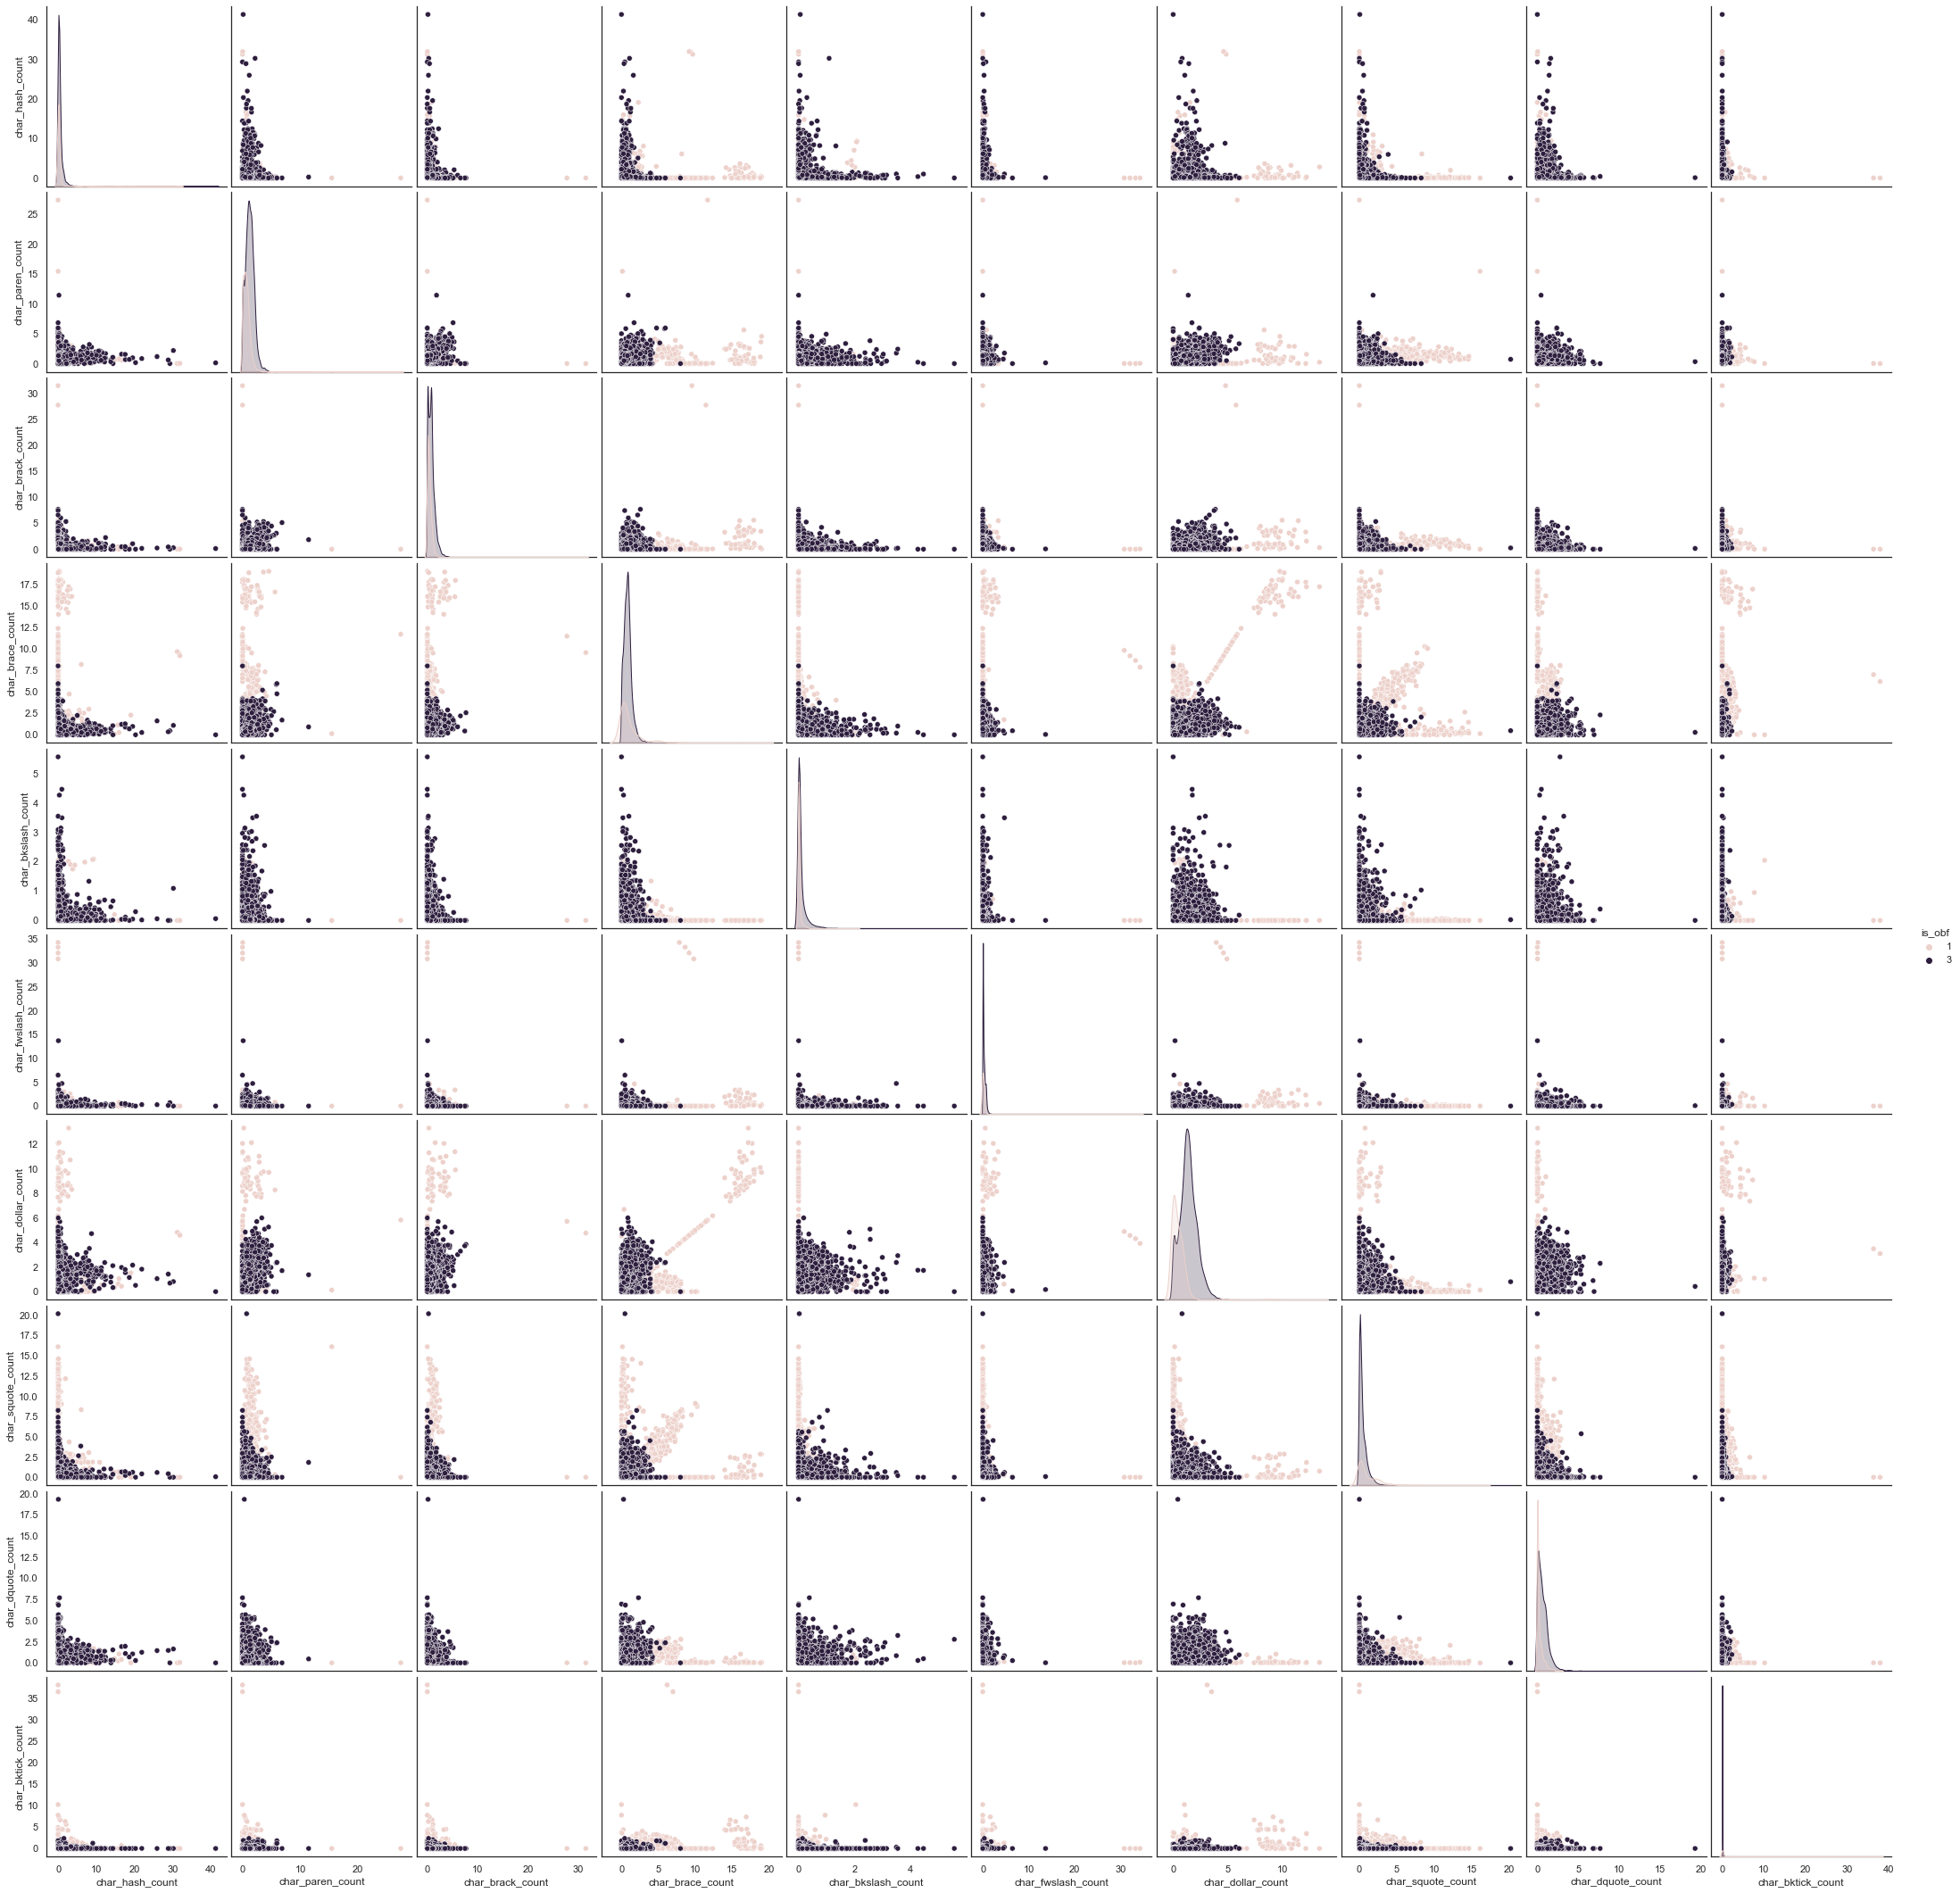

In [88]:
# Pair Plots for features 1:10
sample = delta_data_df.loc[:, :'char_bktick_count']
sns.pairplot(sample, hue="is_obf", height=3)


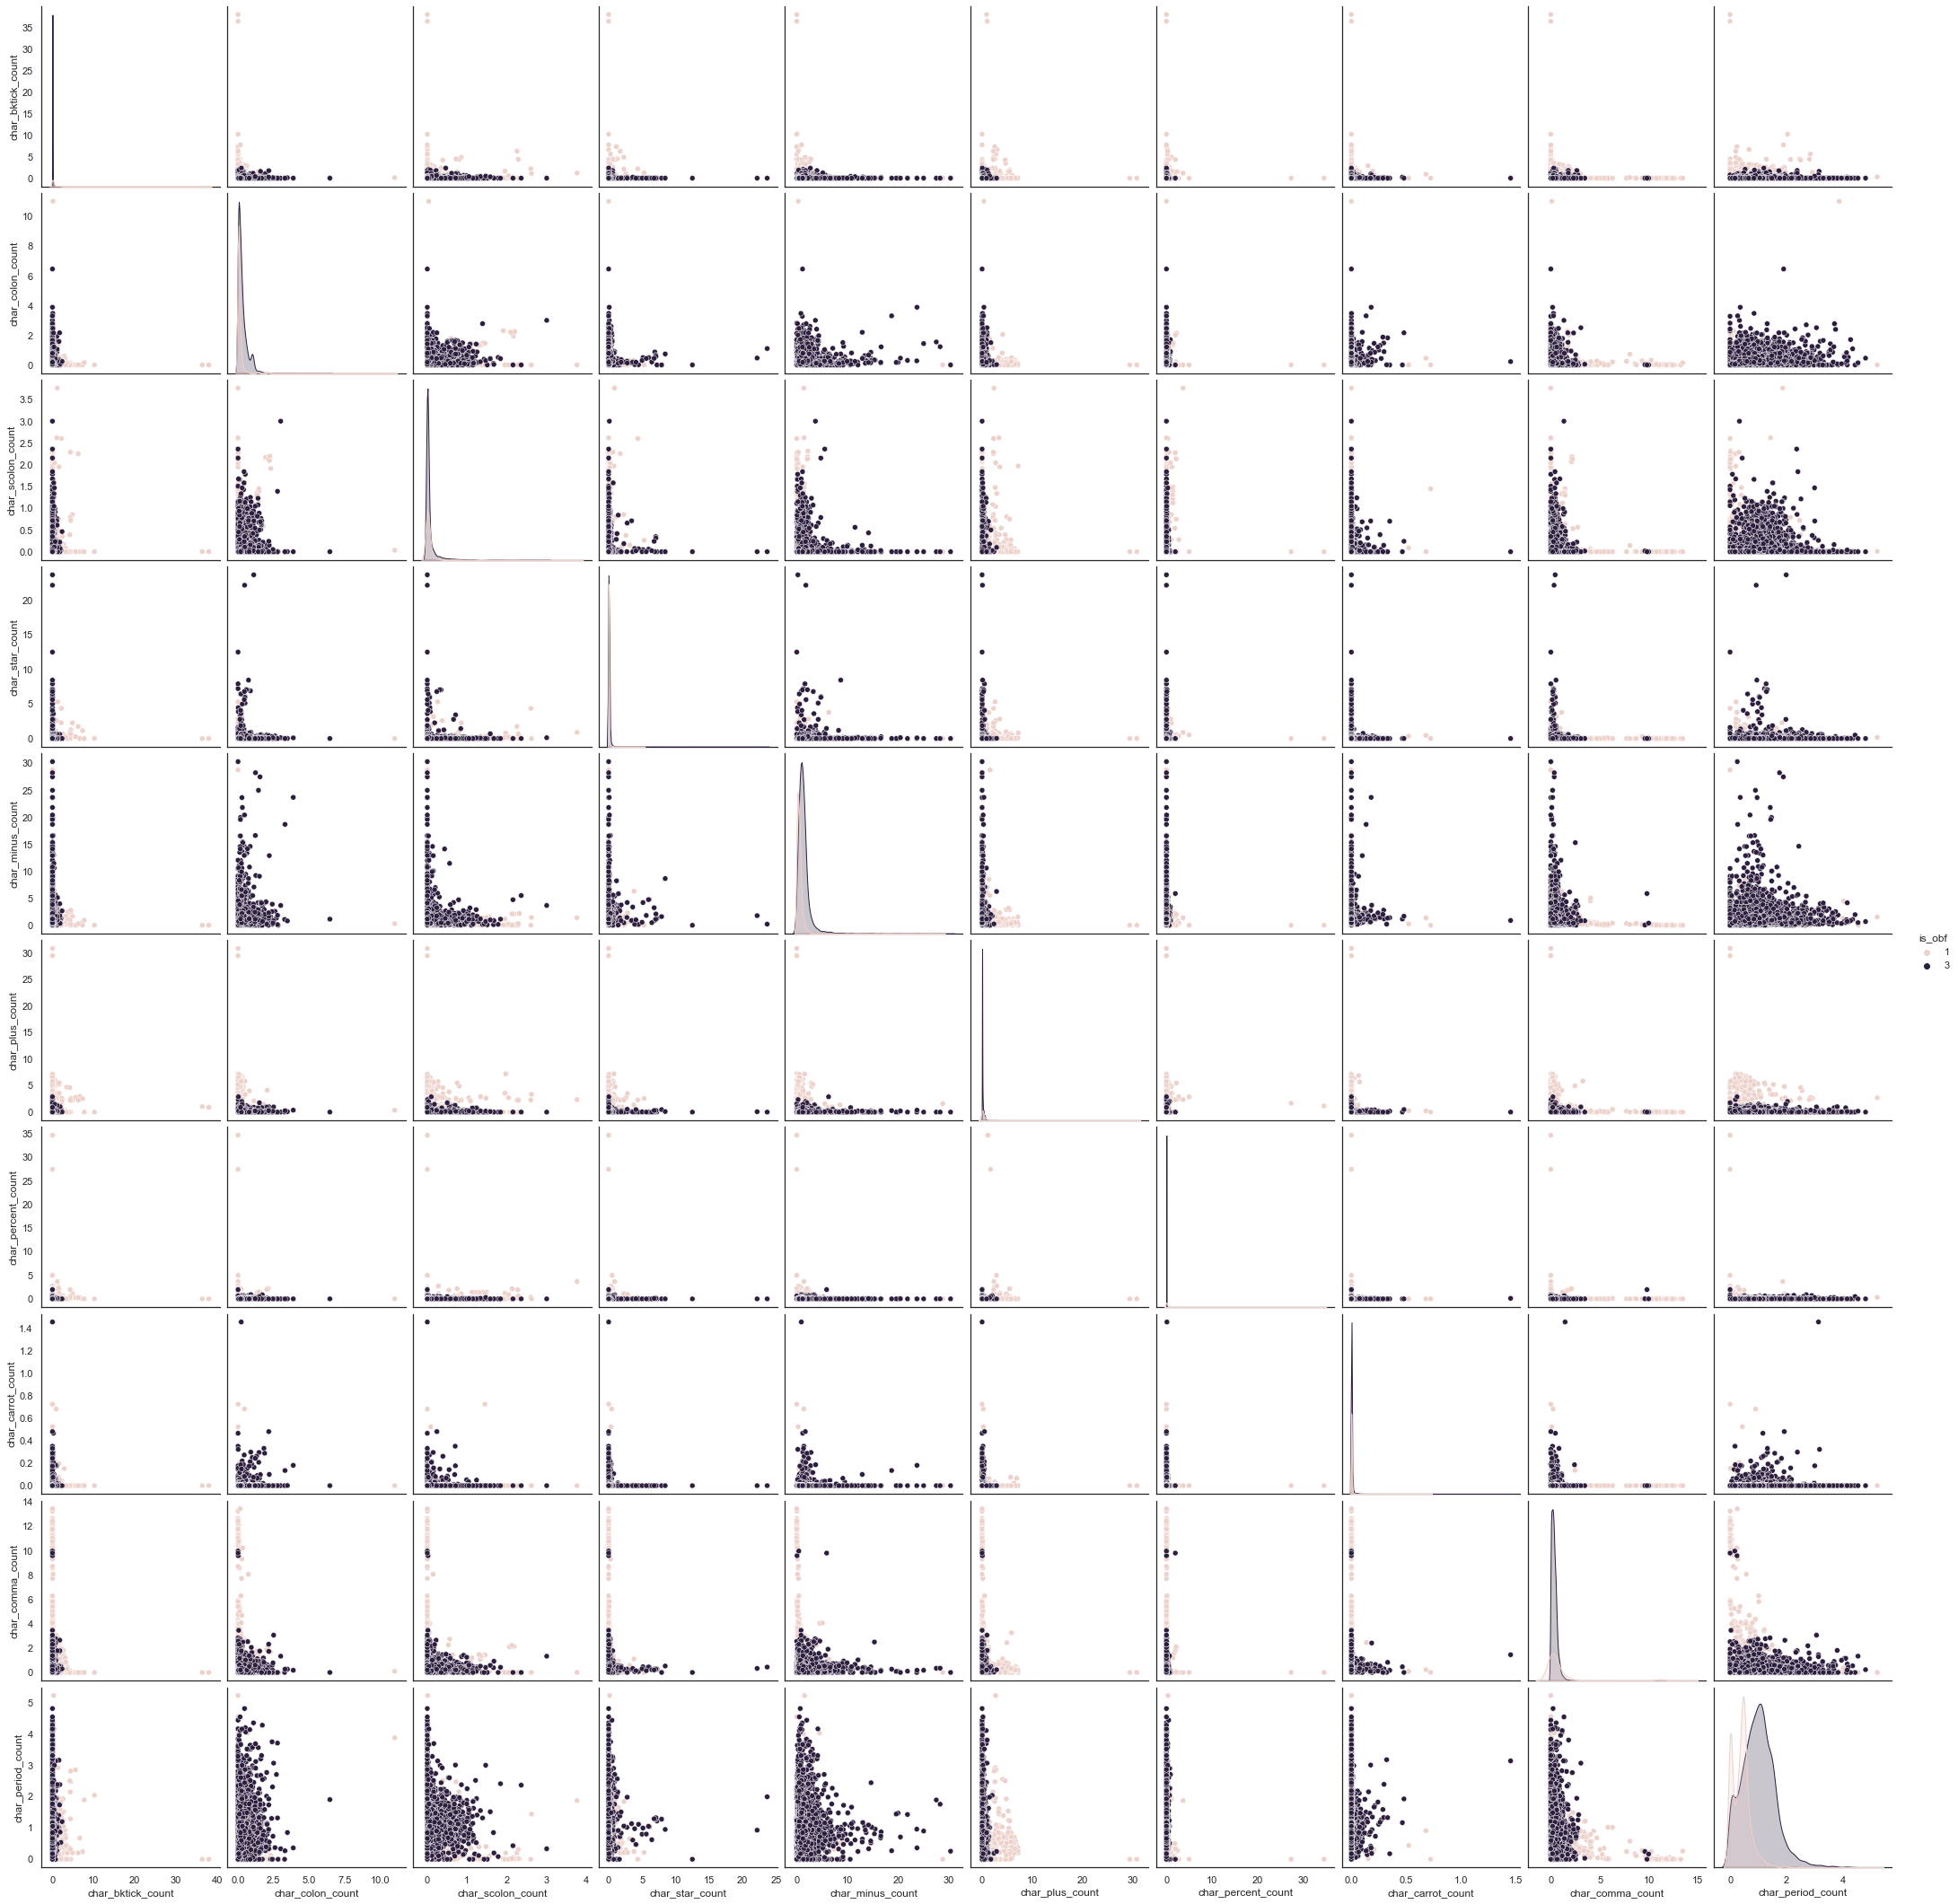

In [89]:
# Pair Plots for features 10:20
sample = delta_data_df.loc[:, 'char_bktick_count':'char_period_count']
sample['is_obf'] = delta_data_df.is_obf
sns.pairplot(sample, hue="is_obf", height=3)

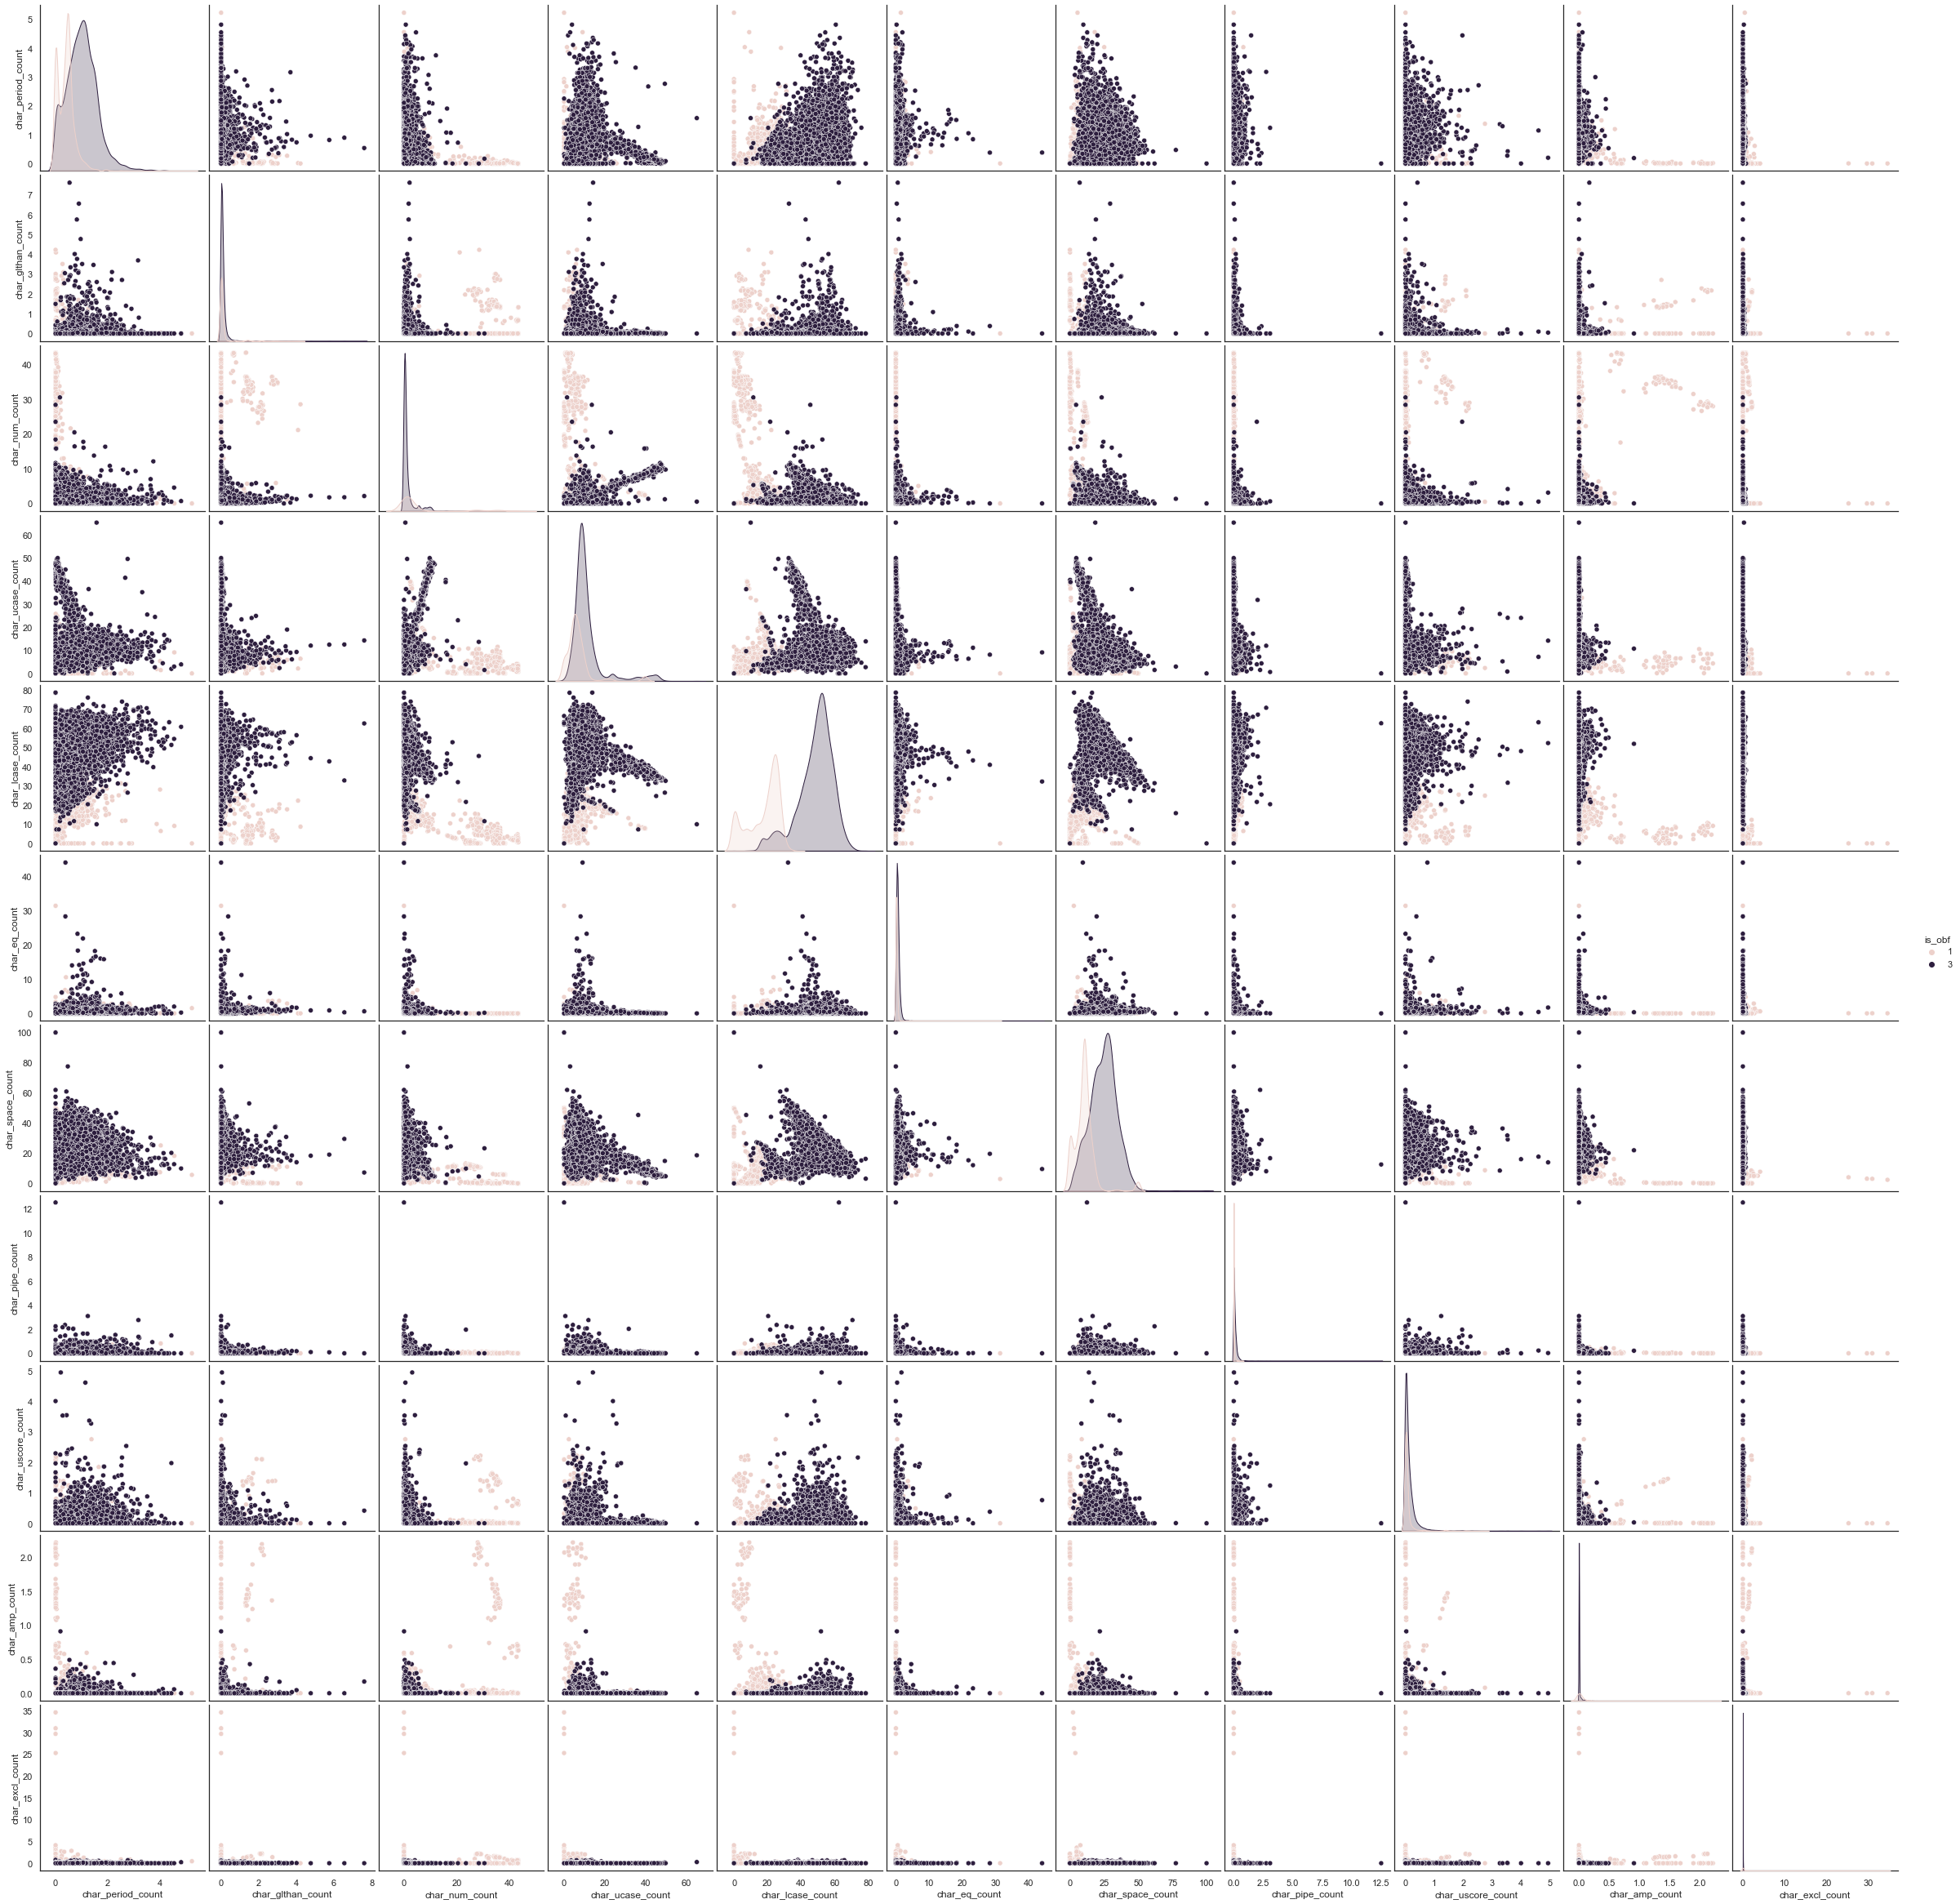

In [90]:
# Pair Plots for features 20:30
sample = delta_data_df.loc[:, 'char_period_count':'char_excl_count']
sample['is_obf'] = delta_data_df.is_obf
sns.pairplot(sample, hue="is_obf", height=3)

Correlation matrix

<AxesSubplot:>

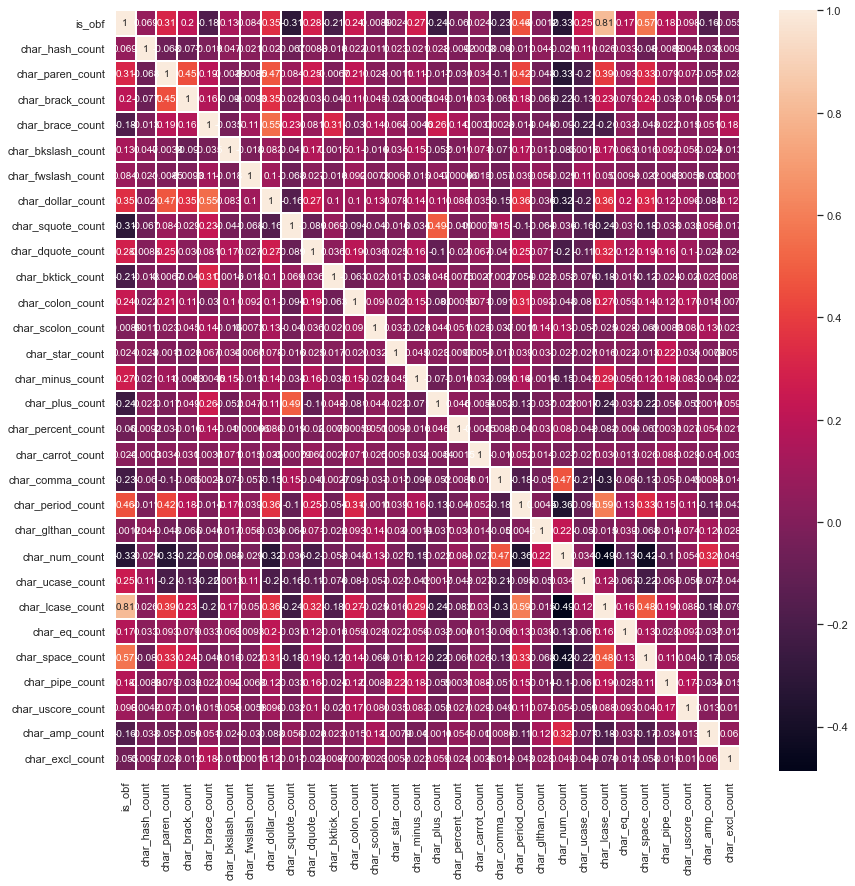

In [91]:
# Creating a correlation matrix heatmap

# Make the correlation matrix from delta dataframe
delta_data_corr_mtrx = delta_data_df.corr()
# Display
fig, ax = plt.subplots(figsize=(14,14))      
sns.heatmap(delta_data_corr_mtrx, annot=True, linewidths=.3, ax=ax)

<AxesSubplot:xlabel='is_obf', ylabel='char_space_count'>

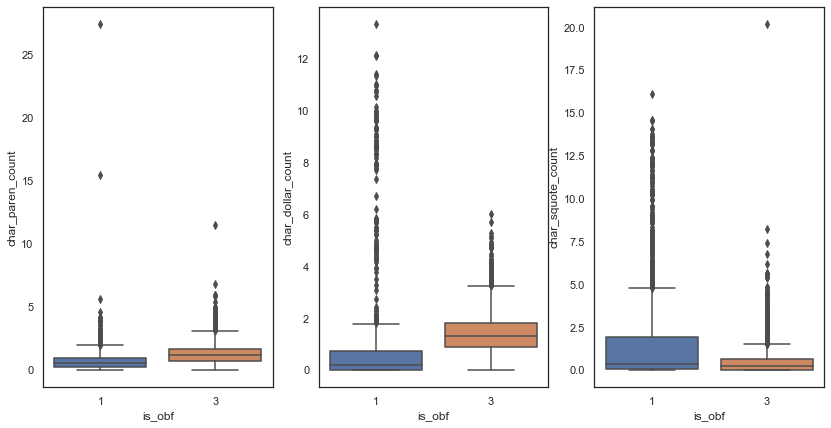

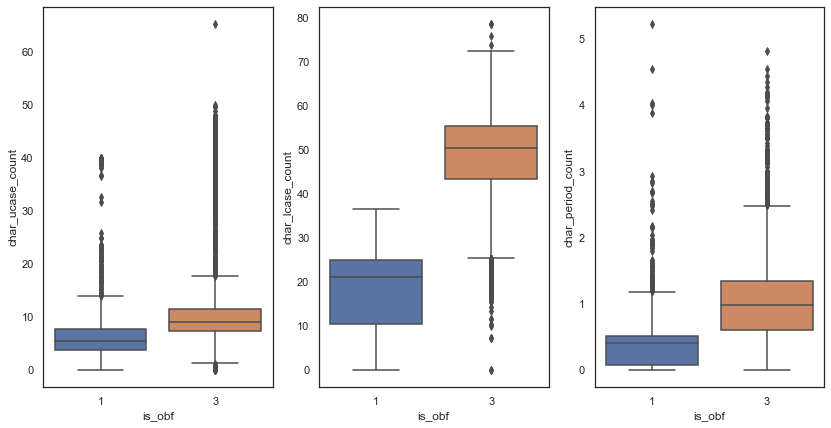

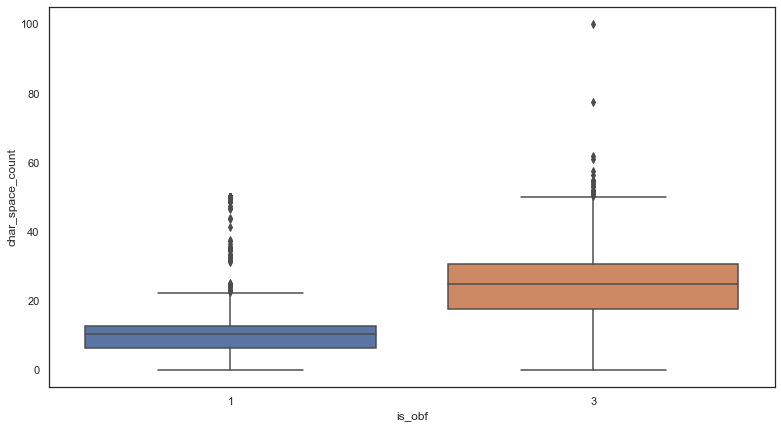

In [92]:
# Box Plots
''' # Loop to display all
for grph, col in enumerate(delta_data_df.columns):
    plt.figure(grph)
'''
# Noteable boxplots
fig, axs = plt.subplots(ncols=3)
fig.set_figheight(7); fig.set_figwidth(14)
sns.boxplot(x=delta_data_df['is_obf'], y=delta_data_df['char_paren_count'], ax=axs[0])
sns.boxplot(x=delta_data_df['is_obf'], y=delta_data_df['char_dollar_count'], ax=axs[1])
sns.boxplot(x=delta_data_df['is_obf'], y=delta_data_df['char_squote_count'], ax=axs[2])

fig, axs = plt.subplots(ncols=3)
fig.set_figheight(7); fig.set_figwidth(14)
sns.boxplot(x=delta_data_df['is_obf'], y=delta_data_df['char_ucase_count'], ax=axs[0])
sns.boxplot(x=delta_data_df['is_obf'], y=delta_data_df['char_lcase_count'], ax=axs[1])
sns.boxplot(x=delta_data_df['is_obf'], y=delta_data_df['char_period_count'], ax=axs[2])

fig, axs = plt.subplots(ncols=1)
fig.set_figheight(7); fig.set_figwidth(13)
sns.boxplot(x=delta_data_df['is_obf'], y=delta_data_df['char_space_count'], ax=axs)

Let's run t-tests on all the remaining features for statistical significance. Assumptions are that for each feature that the means, variance, and 'n' values will be different. This will lead us to set the 'equal_var' argument to False. This means we are performing a Welch's T-Test. The default is set to two-sided. 

In [94]:
# Create a function that will perform a t-test on all the features and return an dictionary of 
# the features along with calculated p-value
def feature_t_tests(dataframe):
    """Takes in pandas df and performs a t-test on all columns that is not
    the target column. The target (is_obf) column what we are testing on.
    Returns Python Dictionary of results."""
    results = dict() # Holds the results and what we are returning

    # Create two data frames that seperate the is_obs
    obs_is_one = dataframe.copy()
    obs_is_one.drop(obs_is_one.loc[obs_is_one['is_obf']==3].index, inplace=True)

    obs_is_three = dataframe.copy()
    obs_is_three.drop(obs_is_three.loc[obs_is_three['is_obf']==1].index, inplace=True)

    # Loop through the list of columns 
    for feat in dataframe.columns.tolist():
        if feat != 'is_obf': # Don't test for the target column
            # perfor a levene test for different variances... sometimes we get insane pvalues so check the test stat too
            l_test_stat, l_p_val = stats.levene(obs_is_one[feat], obs_is_three[feat])

            if (l_p_val < 0.05) and (abs(l_test_stat) > 5):
                # Perform and get test statistic and p-value from Welche's T-Test
                stat, p_val = stats.ttest_ind(obs_is_one[feat], obs_is_three[feat], equal_var=False)
                if abs(stat) > 5 and p_val == 0.0:
                    if stat > 0:
                        p_val = float('inf')
                    else:
                        p_val = float('-inf')
            else: 
                # perform and get test statistic and p-value from standard two sample t-test
                stat, p_val = stats.ttest_ind(obs_is_one[feat], obs_is_three[feat], equal_var=True)
            # Add to dictionary
            results[feat] = (p_val, stat)

    return(results)

p_values_delta_data = feature_t_tests(delta_data_df)
# For fun we can run this on the original dataset too
p_values_orig_data = feature_t_tests(data_df)

# Print Results for Features and p-values sorted by accending
for feat in sorted(p_values_delta_data, key=p_values_delta_data.get, reverse=False):
    print(feat, '\tp-value:', p_values_delta_data[feat][0], '\ttest statistic:', p_values_delta_data[feat][1]) 

char_lcase_count 	p-value: -inf 	test statistic: -149.22896871565362
char_space_count 	p-value: -inf 	test statistic: -74.40764733045381
char_period_count 	p-value: -inf 	test statistic: -62.41270707247039
char_dollar_count 	p-value: 1.2117371067378988e-294 	test statistic: -37.90634295544005
char_minus_count 	p-value: 9.378927337020293e-274 	test statistic: -36.45155344367156
char_dquote_count 	p-value: 2.326988371791908e-264 	test statistic: -35.867489533911495
char_paren_count 	p-value: 8.981124671613028e-217 	test statistic: -32.78746021023744
char_ucase_count 	p-value: 1.7685175775633388e-168 	test statistic: -28.421472206495906
char_colon_count 	p-value: 1.001254916176178e-152 	test statistic: -26.99306912931963
char_pipe_count 	p-value: 8.639622349794347e-142 	test statistic: -25.79233439614171
char_num_count 	p-value: 4.167959254583747e-120 	test statistic: 24.292428023037314
char_squote_count 	p-value: 3.5387336097195284e-117 	test statistic: 23.928062320551543
char_eq_count 	

#### PCA / LDA
A principle component analysis will be used for this data. We are treating it as an unsupervised approach. Lables were added later to the data to hopefully discover some clustering. We will also use original data along side the delta data for comparison. 

In [95]:
# Lets create a copy of and drop that target column so it doesn't intefere with the PCA 
target_df = pd.DataFrame(data_df['is_obf']) # They are both the same so I only need one.
target_nd = pd.DataFrame(data_df['is_obf']).to_numpy() # They are both the same so I only need one.
target_nd = target_nd.ravel() 
# Drop column from DF's 
data_df = data_df.drop(columns=['is_obf'])
delta_data_df = delta_data_df.drop(columns=['is_obf'])

Creating a simple function to determine the best n components for PCA 

In [96]:
# Creating a function to find the optimal n_components for PCA 
def find_opt_n_components(data_set):
	'''Find the number of components that can explain the most data.'''
	set_percentage = .98 # Percentage of data explained

	# The range is the number of components to test
	for comp in range(2, data_set.shape[1]):
		pca = PCA(n_components = comp, random_state=42)
		pca.fit(data_set)
		comp_check = pca.explained_variance_ratio_
		final_comp = comp
		
		if comp_check.sum() >= set_percentage:
			break

	return(final_comp)

opt_n_delta_data = find_opt_n_components(delta_data_df)
print("Optimal n_components for the delta data is {}".format(opt_n_delta_data))

opt_n_data = find_opt_n_components(data_df)
print("Optimal n_components for the original data is {}".format(opt_n_data))

Optimal n_components for the delta data is 6
Optimal n_components for the original data is 5


Now we can create some PCA with our n_components. We will make one for the delta and the original. 

In [97]:
# PCA for the delta 
delta_pca = PCA(n_components=3)
x_delta_pca = delta_pca.fit(delta_data_df).transform(delta_data_df) # Fit and transform
print("[Delta] Explained variance per principal component: {}".format(
	delta_pca.explained_variance_ratio_))

# LDA for Delta
delta_lda = LDA(n_components=1) # Can only be one because we are classifing two targets
x_delta_lda = delta_lda.fit(delta_data_df, target_nd).transform(delta_data_df) # fit data and then transform it

# PCA for the Original Data
orig_pca = PCA(n_components=2)
x_orig_pca = orig_pca.fit(data_df).transform(data_df) # Fit and transform
print("[Original] Explained variance per principal component: {}".format(
	orig_pca.explained_variance_ratio_))

# LDA for Original
orig_lda = LDA(n_components=1) # Can only be one because we are classifing two targets
x_orig_lda = orig_lda.fit(data_df, target_nd).transform(data_df) # fit data and then transform it

[Delta] Explained variance per principal component: [0.63823728 0.18507495 0.08972594]
[Original] Explained variance per principal component: [0.92418105 0.03277296]


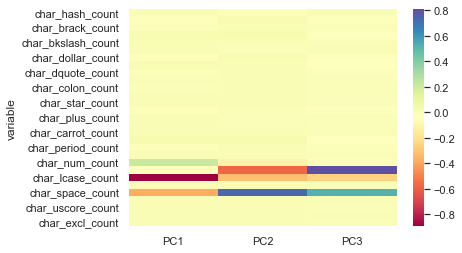

In [98]:
# heatmap graph of PCA components for delta dataset
loadings = delta_pca.fit(delta_data_df).components_
num_pc = delta_pca.fit(delta_data_df).n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = delta_data_df.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

ax = sns.heatmap(loadings_df, annot=False, cmap='Spectral')
plt.show()

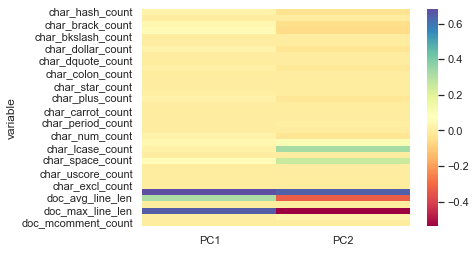

In [99]:
# heatmap graph of PCA components for original dataset
loadings = orig_pca.fit(data_df).components_
num_pc = orig_pca.fit(data_df).n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = data_df.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

ax = sns.heatmap(loadings_df, annot=False, cmap='Spectral')
plt.show()

Plotting PCA/LDA
+ Delta

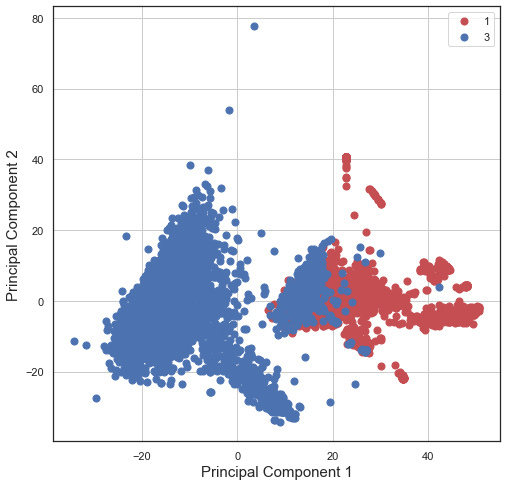

In [100]:
delta_principalDf = pd.DataFrame(data = x_delta_pca[:, :2], columns = ['principal component 1', 'principal component 2'])
# Need to reset the index of the target_df to match the new finalDF
re_target_df = target_df.reset_index(drop=True)
delta_finalDf = pd.concat([delta_principalDf, re_target_df[['is_obf']]], axis=1)

targets = [1, 3]
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
colors = ['r', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = delta_finalDf['is_obf'] == target
    ax.scatter(delta_finalDf.loc[indicesToKeep, 'principal component 1']
               , delta_finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# Not bad. I think an investigation into outliers could help

+ 3D plot of delta

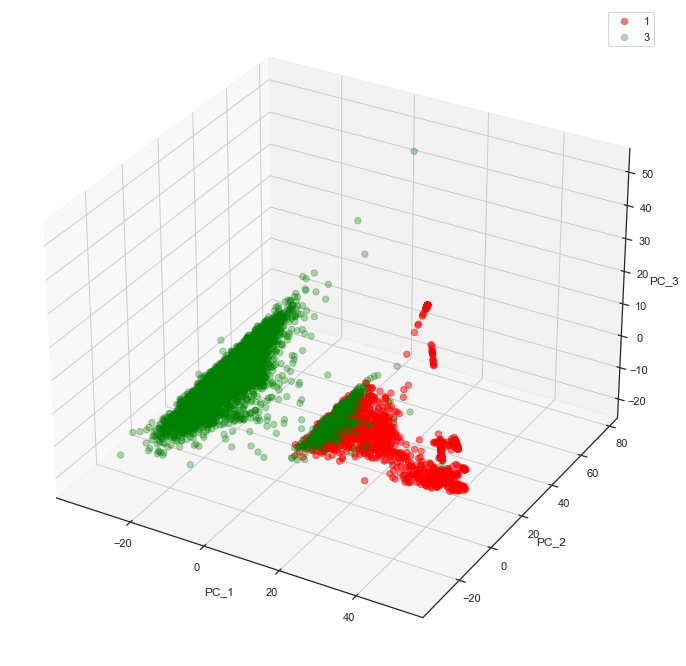

In [101]:
# Start 3D plotting of delta data
delta_3d_df = pd.DataFrame(data = x_delta_pca[:, :3], columns = ['PC_1', 'PC_2', 'PC_3'])
delta_3d_final_df = pd.concat([delta_3d_df, re_target_df[['is_obf']]], axis=1)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection = '3d')

cdict = {1:'red',3:'green'}
labl = {1:'1',3:'3'}
#marker = {1:'*',3:'o'}
alpha = {1:.5, 3:.3}

delta_3d_x = x_delta_pca[:, 0]
delta_3d_y = x_delta_pca[:, 1]
delta_3d_z = x_delta_pca[:, 2]

for l in np.unique(target_nd):
    ix=np.where(target_nd==l)
    ax.scatter(delta_3d_x[ix], delta_3d_y[ix], delta_3d_z[ix], c=cdict[l], s=40,
               label=labl[l],  alpha=alpha[l])

ax.set_xlabel("PC_1")
ax.set_ylabel("PC_2")
ax.set_zlabel("PC_3")

#ax.scatter(delta_3d_x, delta_3d_y, delta_3d_z)
ax.legend()
plt.show()

+ Original Data

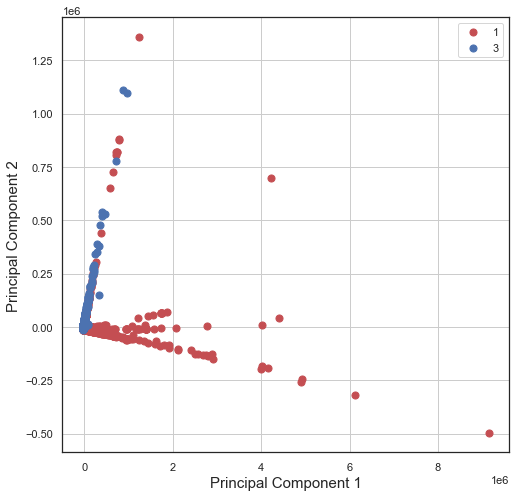

In [102]:
orig_principalDf = pd.DataFrame(data = x_orig_pca, columns = ['principal component 1', 'principal component 2'])
# Need to reset the index of the target_df to match the new finalDF
re_target_df = target_df.reset_index(drop=True)
orig_finalDf = pd.concat([orig_principalDf, re_target_df[['is_obf']]], axis=1)

targets = [1, 3]
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
colors = ['r', 'b']
for target, color in zip(targets, colors):
    indicesToKeep = orig_finalDf['is_obf'] == target
    ax.scatter(orig_finalDf.loc[indicesToKeep, 'principal component 1']
               , orig_finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# The n_components might explain more in fewer...but the graph does not explain much